In [1]:
%run libreria.py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import utm
import pandas as pd
import math
from matplotlib.pyplot import figure
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pymysql


In [2]:
def get_connection():
    return pymysql.connect(host='ec2-18-221-141-77.us-east-2.compute.amazonaws.com',
                             user='root',
                             password='password',
                             db='dbname',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)


In [3]:
conn=get_connection()
with conn.cursor() as cursor:
    sql="select * from tasks_abejas where task_completed>0 and task_name like \"%montecarlo%\""
    cursor.execute(sql)
    result = cursor.fetchall()
conn.close()



ProgrammingError: (1146, "Table 'dbname.tasks_abejas' doesn't exist")

In [4]:
def remove_bootstrap(strong):
    u=strong.split("\"bootstrap\":")
    return u[0]+"%"+u[1][u[1].find(","):]

generic_task=[]
for  r in result:
    generic_task.append(remove_bootstrap(r["task_params"]))
    
generic_task=list(set(generic_task))

In [5]:
distancias_mutuas={}
distancias_origen={}

i=0
for a in generic_task:
    print(str(i)+"/"+str(len(generic_task)), end="          \r")
    i+=1
    conn=get_connection()
    with conn.cursor() as cursor:
        sql="select * from tasks_abejas where task_params like \""+a.replace("\"", "\\\"")+"\""
        cursor.execute(sql)
        aa = cursor.fetchall()
    lista_difs=[str(aaa["task_id"]) for aaa in aa]
    condit="("+", ".join(lista_difs)+")"
    with conn.cursor() as cursor:
        sql="select distancia from distancias_geom where ca in "+condit+"  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
    distancias_mutuas[a]=[aaa["distancia"] for aaa in aa]
    with conn.cursor() as cursor:
        sql="select distancia from distancias_geom where ca=0  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
    conn.close()
    distancias_origen[a]=[aaa["distancia"] for aaa in aa]


In [6]:
import random
d2=1
from scipy.stats import gmean

dic_res_2={}

dict_funs_r={"Uniform":"random.uniform", "Exponential":"random.expovariate", "Normal":"random.normalvariate", "Lognormal":"random.lognormvariate"}

dict_funs={"random.uniform":"Uniform", "random.expovariate":"Exponential", "random.normalvariate":"Normal", "random.lognormvariate":"Lognormal"}

dict_params={"random.uniform":["a", "b"], "random.expovariate":["lambd"], "random.normalvariate":["mu", "sigma"], "random.lognormvariate":["mu", "sigma"]}

for k in dict_funs:
    dic_res_2[dict_funs[k]]={}
    
i=0
for task in result:
    print(str(i)+"/"+str(len(result)), end="       \r")
    i+=1
    params=eval(task["task_params"])
    funi_ind=task["task_params"].find("randomfun")
    funi=task["task_params"][funi_ind+11:]
    funi=funi[:funi.find(",")]
    
    
    fun=dict_funs[funi]
    pms=dict_params[funi]
    params=tuple([params["params"][p] for p in pms])
    otro_nombre=remove_bootstrap(task["task_params"])
    dic_res_2[fun][params]={"origen":distancias_origen[otro_nombre], 
                            "mutual":distancias_mutuas[otro_nombre]}
    
    
    
    

1307/10100

2583/10100

3832/10100

5087/10100

8871/10100

In [7]:
nl=[]
for fun in dic_res_2:
    for params in dic_res_2[fun]:
        if len(dic_res_2[fun][params]["mutual"])>10:
            nd={"Fun":fun, "params":str(params), "areas_mean":np.mean(dic_res_2[fun][params]["origen"]), 
                "areas_median":np.median(dic_res_2[fun][params]["origen"]),
                "p5":np.percentile(dic_res_2[fun][params]["origen"],5), "p25":np.percentile(dic_res_2[fun][params]["origen"],25), 
                "p95":np.percentile(dic_res_2[fun][params]["origen"],95), "p75":np.percentile(dic_res_2[fun][params]["origen"],75),
                "len":len(dic_res_2[fun][params]["origen"]), "todos":dic_res_2[fun][params]["origen"],
                "min":np.min(dic_res_2[fun][params]["origen"]), "max":np.max(dic_res_2[fun][params]["origen"]), 
                "areas_mean_mutual":np.mean(dic_res_2[fun][params]["mutual"]), 
                "areas_median_mutual":np.median(dic_res_2[fun][params]["mutual"]),
                "p5_mutual":np.percentile(dic_res_2[fun][params]["mutual"],5), "p25_mutual":np.percentile(dic_res_2[fun][params]["mutual"],25), 
                "p95_mutual":np.percentile(dic_res_2[fun][params]["mutual"],95), "p75_mutual":np.percentile(dic_res_2[fun][params]["mutual"],75),
                "len_mutual":len(dic_res_2[fun][params]["mutual"]), "todos_mutual":dic_res_2[fun][params]["mutual"],
                "min_mutual":np.min(dic_res_2[fun][params]["mutual"]), "max_mutual":np.max(dic_res_2[fun][params]["mutual"])}
            nl.append(nd)
        


In [61]:
def get_mean(fun, params):
    if fun=="Exponential": return 1/params[0]
    if fun=="Normal": 
        mostra=[]
        while len(mostra)<10000:
            ran=random.normalvariate(params[0], params[1])
            if ran>0:
                mostra.append(ran)
        return np.mean(mostra)
    if fun=="Uniform": 
        return (params[1]-params[0])/2
    if fun=="Lognormal": return math.exp(params[0]+params[1]/2)
    
def get_var(fun, params):
    if fun=="Exponential": return 1/(params[0]**2)
    if fun=="Normal": 
        mostra=[]
        while len(mostra)<10000:
            ran=random.normalvariate(params[0], params[1])
            if ran>0:
                mostra.append(ran)
        return np.var(mostra)
    if fun=="Uniform": 
        return (params[1]-params[0])**2/12
    if fun=="Lognormal": return (math.exp(params[1])-1)*math.exp(2*params[0]+params[1])
    
def get_var_log(fun, params):
    if fun=="Exponential": return 1/(params[0]**2)
    if fun=="Normal": 
        mostra=[]
        while len(mostra)<10000:
            ran=random.normalvariate(params[0], params[1])
            if ran>0:
                mostra.append(ran)
        return np.var(mostra)
    if fun=="Uniform": 
        return (params[1]-params[0])**2/12
    if fun=="Lognormal": return params[1]
    
    
def get_var_nor(fun, params):
    if fun=="Exponential": return 1/(params[0]**2)
    if fun=="Normal": 
        return params[1]
    if fun=="Uniform": 
        return (params[1]-params[0])**2/12
    if fun=="Lognormal": return params[1]
    
df=pd.DataFrame(nl)

df["mean"]=[get_mean(fun, eval(params)) for fun, params in zip(df["Fun"], df["params"])]
df["varianza"]=[get_var(fun, eval(params)) for fun, params in zip(df["Fun"], df["params"])]
df["varianza_log"]=[get_var_log(fun, eval(params)) for fun, params in zip(df["Fun"], df["params"])]
df["varianza_nor"]=[get_var_nor(fun, eval(params)) for fun, params in zip(df["Fun"], df["params"])]


No handles with labels found to put in legend.


Text(0.5, 0, 'Mean of distribution')

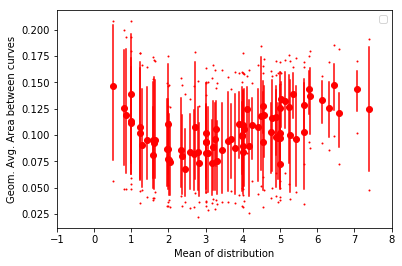

In [9]:

#for curva in set(df["Fun"]):
#    plt.scatter( df[df.Fun==curva]["mean"], df[df.Fun==curva].areas_mean, label=curva)

for i in df.iterrows():
    noise=0
    plt.scatter(i[1]["mean"]+noise , i[1]["areas_mean"],  color="r")
    plt.scatter(i[1]["mean"]+noise , i[1]["min"],  color="r", s=1)
    plt.scatter(i[1]["mean"]+noise , i[1]["max"],  color="r", s=1)
    plt.plot([i[1]["mean"]+noise,i[1]["mean"]+noise] , [i[1]["p5"],i[1]["p95"]], '-', color="r")
    
plt.xlim([-1,8])
plt.legend()
plt.ylabel("Geom. Avg. Area between curves")
plt.xlabel("Mean of distribution")


No handles with labels found to put in legend.


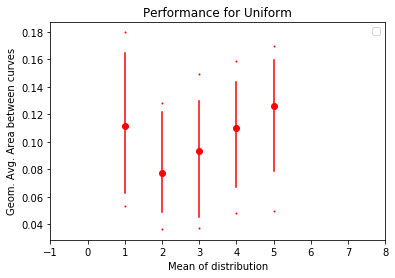

No handles with labels found to put in legend.


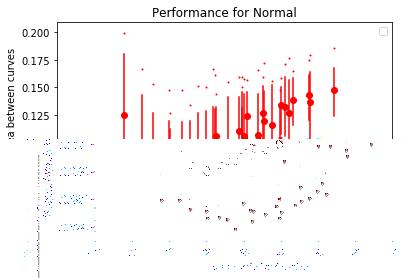

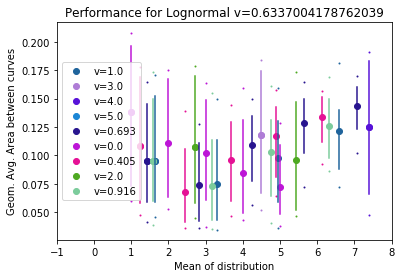

No handles with labels found to put in legend.


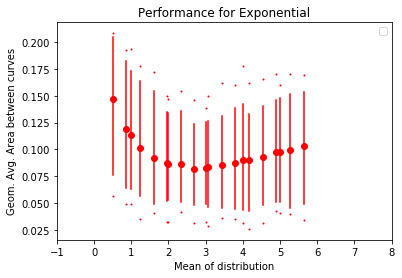

In [10]:
#for curva in set(df["Fun"]):
#    plt.scatter( df[df.Fun==curva]["mean"], df[df.Fun==curva].areas_mean, label=curva)
colorines={}
for funs in set(list(df.Fun)):
    if funs=="Lognormal":
        variansas=list(set(df["varianza_log"]))
        for var in variansas:
            for i in df[(df.Fun==funs) & (df.varianza_log==var)].iterrows():
                noise=0
                if var not in colorines:
                    colorines[var]=(random.random(),random.random(),random.random() )
                    plt.scatter(i[1]["mean"]+noise , i[1]["areas_mean"],  color=colorines[var], label="v="+str(var))
                nc=colorines[var]
                plt.scatter(i[1]["mean"]+noise , i[1]["areas_mean"],  color=nc)
                plt.scatter(i[1]["mean"]+noise , i[1]["min"],  color=nc, s=1)
                plt.scatter(i[1]["mean"]+noise , i[1]["max"],  color=nc, s=1)
                plt.plot([i[1]["mean"]+noise,i[1]["mean"]+noise] , [i[1]["p5"],i[1]["p95"]], '-', color=nc)
        plt.title("Performance for "+funs+" v="+str(var))
        plt.xlim([-1,8])
        plt.legend()
        plt.ylabel("Geom. Avg. Area between curves")
        plt.xlabel("Mean of distribution")
        plt.show()
    else:
        for i in df[df.Fun==funs].iterrows():
            noise=0
            plt.scatter(i[1]["mean"]+noise , i[1]["areas_mean"],  color="r")
            plt.scatter(i[1]["mean"]+noise , i[1]["min"],  color="r", s=1)
            plt.scatter(i[1]["mean"]+noise , i[1]["max"],  color="r", s=1)
            plt.plot([i[1]["mean"]+noise,i[1]["mean"]+noise] , [i[1]["p5"],i[1]["p95"]], '-', color="r")
            plt.title("Performance for "+funs)

        plt.xlim([-1,8])
        plt.legend()
        plt.ylabel("Geom. Avg. Area between curves")
        plt.xlabel("Mean of distribution")
        plt.show()


In [60]:
df[df.Fun=="Normal"]

Fun  areas_mean  areas_mean_mutual  areas_median  areas_median_mutual  \
25  Normal    0.091002           0.100331      0.084750             0.094237   
26  Normal    0.125462           0.096478      0.123385             0.087444   
27  Normal    0.080807           0.098470      0.076701             0.092413   
28  Normal    0.080630           0.085247      0.079885             0.078035   
29  Normal    0.088644           0.075831      0.090938             0.069238   
30  Normal    0.098731           0.068271      0.103918             0.061881   
31  Normal    0.076269           0.085740      0.075073             0.079354   
32  Normal    0.084318           0.075238      0.081627             0.069324   
33  Normal    0.094570           0.067408      0.098214             0.062099   
34  Normal    0.107503           0.061630      0.112323             0.056214   
35  Normal    0.074244           0.078226      0.070430             0.073464   
36  Normal    0.084272           0.071189      0.082983             0.066716   
37  Normal    0.095978           0.065724      0.099869             0.059897   
38  Normal    0.105985           0.060500      0.111789             0.055417   
39  Normal    0.116304           0.054964      0.120319             0.049813   
40  Normal    0.093045           0.062514      0.092588             0.058956   
41  Normal    0.106212           0.054041      0.110318             0.051480   
42  Normal    0.110702           0.052805      0.115365             0.049534   
43  Normal    0.119394           0.049886      0.123244             0.046976   
44  Normal    0.126958           0.048131      0.132885             0.044145   
45  Normal    0.099650           0.052546      0.101090             0.048184   
46  Normal    0.124351           0.041231      0.127845             0.039436   
47  Normal    0.127222           0.042900      0.128669             0.040707   
48  Normal    0.132531           0.042233      0.133857             0.040061   
49  Normal    0.137105           0.041490      0.139387             0.039243   
50  Normal    0.102168           0.047070      0.103292             0.044276   
51  Normal    0.134434           0.034945      0.136815             0.033493   
52  Normal    0.138885           0.034329      0.140807             0.033135   
53  Normal    0.143378           0.035368      0.144277             0.033666   
54  Normal    0.147324           0.036425      0.149449             0.035199   

    len  len_mutual       max  max_mutual       min  ...       p75  \
25  100        4932  0.166863    0.267928  0.048182  ...  0.112730   
26  100        4929  0.199571    0.297192  0.048425  ...  0.157631   
27   99        4932  0.153004    0.266129  0.040005  ...  0.094179   
28  100        4935  0.147888    0.240478  0.033156  ...  0.096779   
29  100        4926  0.166291    0.218009  0.039132  ...  0.105538   
30  100        4928  0.159638    0.207183  0.032257  ...  0.116347   
31  100        4934  0.147379    0.250753  0.038279  ...  0.090403   
32   98        4933  0.151480    0.223525  0.021870  ...  0.104535   
33  100        4936  0.154780    0.198756  0.036225  ...  0.115093   
34  100        4938  0.166111    0.190945  0.044091  ...  0.128666   
35  100        4932  0.126741    0.210074  0.031896  ...  0.087765   
36  100        4941  0.133877    0.223220  0.031206  ...  0.105152   
37  100        4934  0.161623    0.214316  0.029760  ...  0.116331   
38  100        4935  0.157803    0.168418  0.037308  ...  0.124614   
39  100        4930  0.156185    0.162280  0.050160  ...  0.134687   
40  100        4938  0.150495    0.208051  0.045966  ...  0.108291   
41  100        4940  0.144255    0.146276  0.038645  ...  0.118046   
42   99        4932  0.159342    0.147403  0.043146  ...  0.127638   
43  100        4937  0.171965    0.133914  0.047575  ...  0.137192   
44  100        4932  0.176281    0.133084  0.053582  ...  0.143503   
45  100        4936  0.150304    0.134383  0.049445  ...

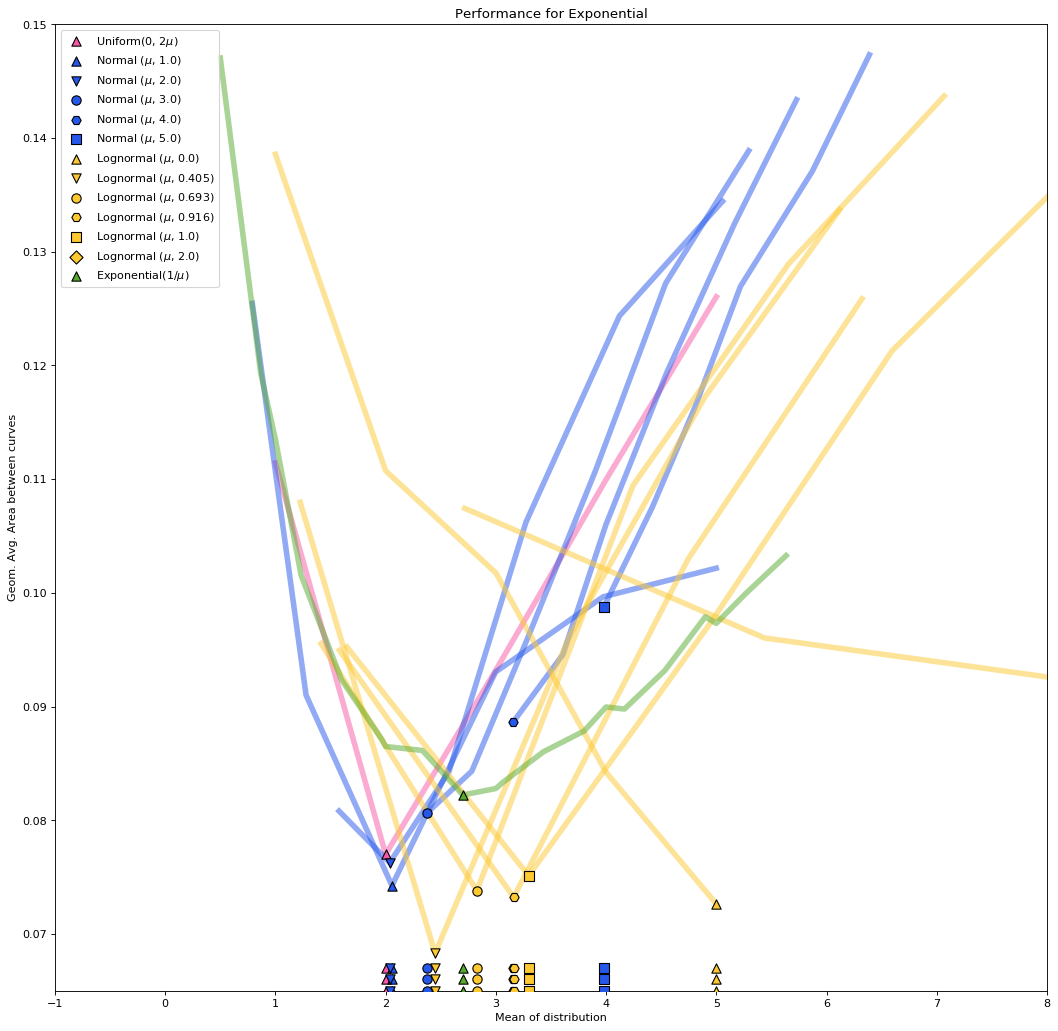

In [116]:
#for curva in set(df["Fun"]):
##
#    plt.scatter( df[df.Fun==curva]["mean"], df[df.Fun==curva].areas_mean, label=curva)
f=figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
markers=["^", "v", "o", "H", "s", "D"]
for funs in set(list(df.Fun)):
    
    if funs=="Uniform" or funs=="Exponential":
        c1="#f857a6"
        lab=funs+"(0, 2$\mu$)"
        if funs=="Exponential":
            c1="#56ab2f"
            lab=funs+"($1/\mu$)"
        c2=c1
        color=gradient(c1, c2,0.5)
        x=[]
        y=[]
        for i in df[(df.Fun==funs)].sort_values("mean").iterrows():
            x.append(i[1]["mean"])
            y.append(i[1]["areas_mean"])
        if np.min(x)<6:
            plt.plot(x, y,  c=color, linewidth=5, alpha=0.5)
            mini=np.min(y)
            plt.scatter(x[y.index(mini)], mini,label=lab, edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[0], zorder=50)
            plt.scatter(x[y.index(mini)], 0.065,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[0], zorder=50)
            plt.scatter(x[y.index(mini)], 0.066,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[0], zorder=50)
            plt.scatter(x[y.index(mini)], 0.067,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[0], zorder=50)

    
    elif funs=="Lognormal":
        c1="#FDC830"
        c2="#FDC830"
        variansas=sorted([float(k) for k in list(set(df[df.Fun==funs]["varianza_log"]))])
        if 3 in variansas:
            variansas.remove(3)
            
        markr=0
        for var in variansas:
            scala=(var-np.min(variansas))/(np.max(variansas)-np.min(variansas))
            color=gradient(c1, c2,scala)
            x=[]
            y=[]
            for i in df[(df.Fun==funs) & (df.varianza_log==var)].sort_values("mean").iterrows():
                x.append(i[1]["mean"])
                y.append(i[1]["areas_mean"])
            if np.min(x)<6:
                plt.plot(x, y,  c=color, linewidth=5, alpha=0.5)
                mini=np.min(y)
                plt.scatter(x[y.index(mini)], mini,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50)
                plt.scatter(9, mini,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr],  label=funs+" ($\mu$, "+str(var)+")")
                plt.scatter(x[y.index(mini)], 0.065,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50)
                plt.scatter(x[y.index(mini)], 0.066,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50)
                plt.scatter(x[y.index(mini)], 0.067,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50)

                markr+=1
                    
    elif funs=="Normal":
        markr=0
        variansas=list(set(df[df.Fun==funs]["varianza_nor"]))
        for var in variansas:
                c1="#2657eb"
                c2=c1
                scala=(var-np.min(variansas))/(np.max(variansas)-np.min(variansas))
                color=gradient(c1, c2,scala)
                x=[]
                y=[]
                for i in df[(df.Fun==funs) & (df.varianza_nor==var)].sort_values("mean").iterrows():
                    x.append(i[1]["mean"])
                    y.append(i[1]["areas_mean"])
                if np.min(x)<6:
                    plt.plot(x, y,  c=color, linewidth=5, alpha=0.5)
                    mini=np.min(y)
                    plt.scatter(x[y.index(mini)], mini,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50, label=funs+" ($\mu$, "+str(var)+")")
                    plt.scatter(x[y.index(mini)], 0.065,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50)
                    plt.scatter(x[y.index(mini)], 0.066,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50)
                    plt.scatter(x[y.index(mini)], 0.067,edgecolor=[(0,0,0)], c=[color], s=70, marker=markers[markr], zorder=50)
                    markr+=1
                    
    elif funs=="1Normal":
        x=[]
        y=[]
        for i in df[(df.Fun==funs)].sort_values("mean").iterrows():
            x.append(i[1]["mean"])
            y.append(i[1]["areas_mean"])
        mini=np.min(y)
        plt.scatter(x[y.index(mini)], mini)

        plt.plot(x, y, label=funs+"($\mu$, $v$), $v \in \{1, 2, 3, 4, 5\}$" )
        
    else:
        x=[]
        y=[]
        for i in df[df.Fun==funs].sort_values("mean").iterrows():
            x.append(i[1]["mean"])
            y.append(i[1]["areas_mean"])
        mini=np.min(y)
        plt.scatter(x[y.index(mini)], mini)

        plt.plot(x, y, label=funs+" (1/$\mu$)")
plt.legend()
plt.xlim([-1,8])
plt.ylim([0.065,0.15])

plt.ylabel("Geom. Avg. Area between curves")
plt.xlabel("Mean of distribution")
plt.title("Performance for "+funs)

f.savefig("figura_b.pdf")


In [109]:
import pickle 
ff=open("fig1.pkl", "wb")
pickle.dump(f, ff)
ff.close()

In [35]:
df[df.Fun=="Normal"].sort_values("mean")[["areas_mean", "mean", "varianza"]]

areas_mean      mean   varianza
26    0.125462  0.792997   0.365650
25    0.091002  1.297674   0.627454
27    0.080807  1.591031   1.475618
31    0.076269  2.007215   1.897862
35    0.074244  2.044854   0.891080
28    0.080630  2.367921   3.281260
36    0.084272  2.577571   2.539644
32    0.084318  2.802028   3.925906
40    0.093045  3.015476   0.981153
29    0.088644  3.185133   5.800445
37    0.095978  3.249801   4.777867
41    0.106212  3.267882   3.099943
33    0.094570  3.590468   6.761831
42    0.110702  3.885353   5.649937
45    0.099650  3.982697   1.008745
30    0.098731  3.984534   9.199527
38    0.105985  4.031261   7.889819
46    0.124351  4.108287   3.486255
34    0.107503  4.403745  10.244169
47    0.127222  4.541098   6.612007
43    0.119394  4.563030   8.825140
39    0.116304  4.775055  11.256644
50    0.102168  4.994370   1.010966
51    0.134434  5.017954   3.829209
48    0.132531  5.120944  10.226141
44    0.126958  5.243387  12.927548
52    0.138885  5.355876   7.341756
53    0.143378  5.785017  11.418495
49    0.137105  5.817384  14.420349
54    0.147324  6.448734  15.995976

In [13]:
from scipy.stats import ks_2samp

resultats={}
for i in df.iterrows():
    nr=[]
    for j in df.iterrows():
        res=ks_2samp(i[1]["todos"], j[1]["todos"])
        resultats[(i[0], j[0])]=res.pvalue



In [14]:
neworder=[85]
while len(neworder)<len(df):
    maxi=0
    inds=0
    for k in resultats:
        for s in neworder:
            if k[0]==s and k[1] not in neworder and maxi<resultats[k]:
                maxi=resultats[k]
                inds=k[1]
    neworder.append(inds)
                
        

In [15]:
neworder2=[]
while len(neworder2)<len(df):
    maxi=math.inf
    inds=0
    for k in df.iterrows():
        if k[0] not in neworder2 and maxi>k[1]["mean"]:
            maxi=k[1]["mean"]
            inds=k[0]
    neworder2.append(inds)

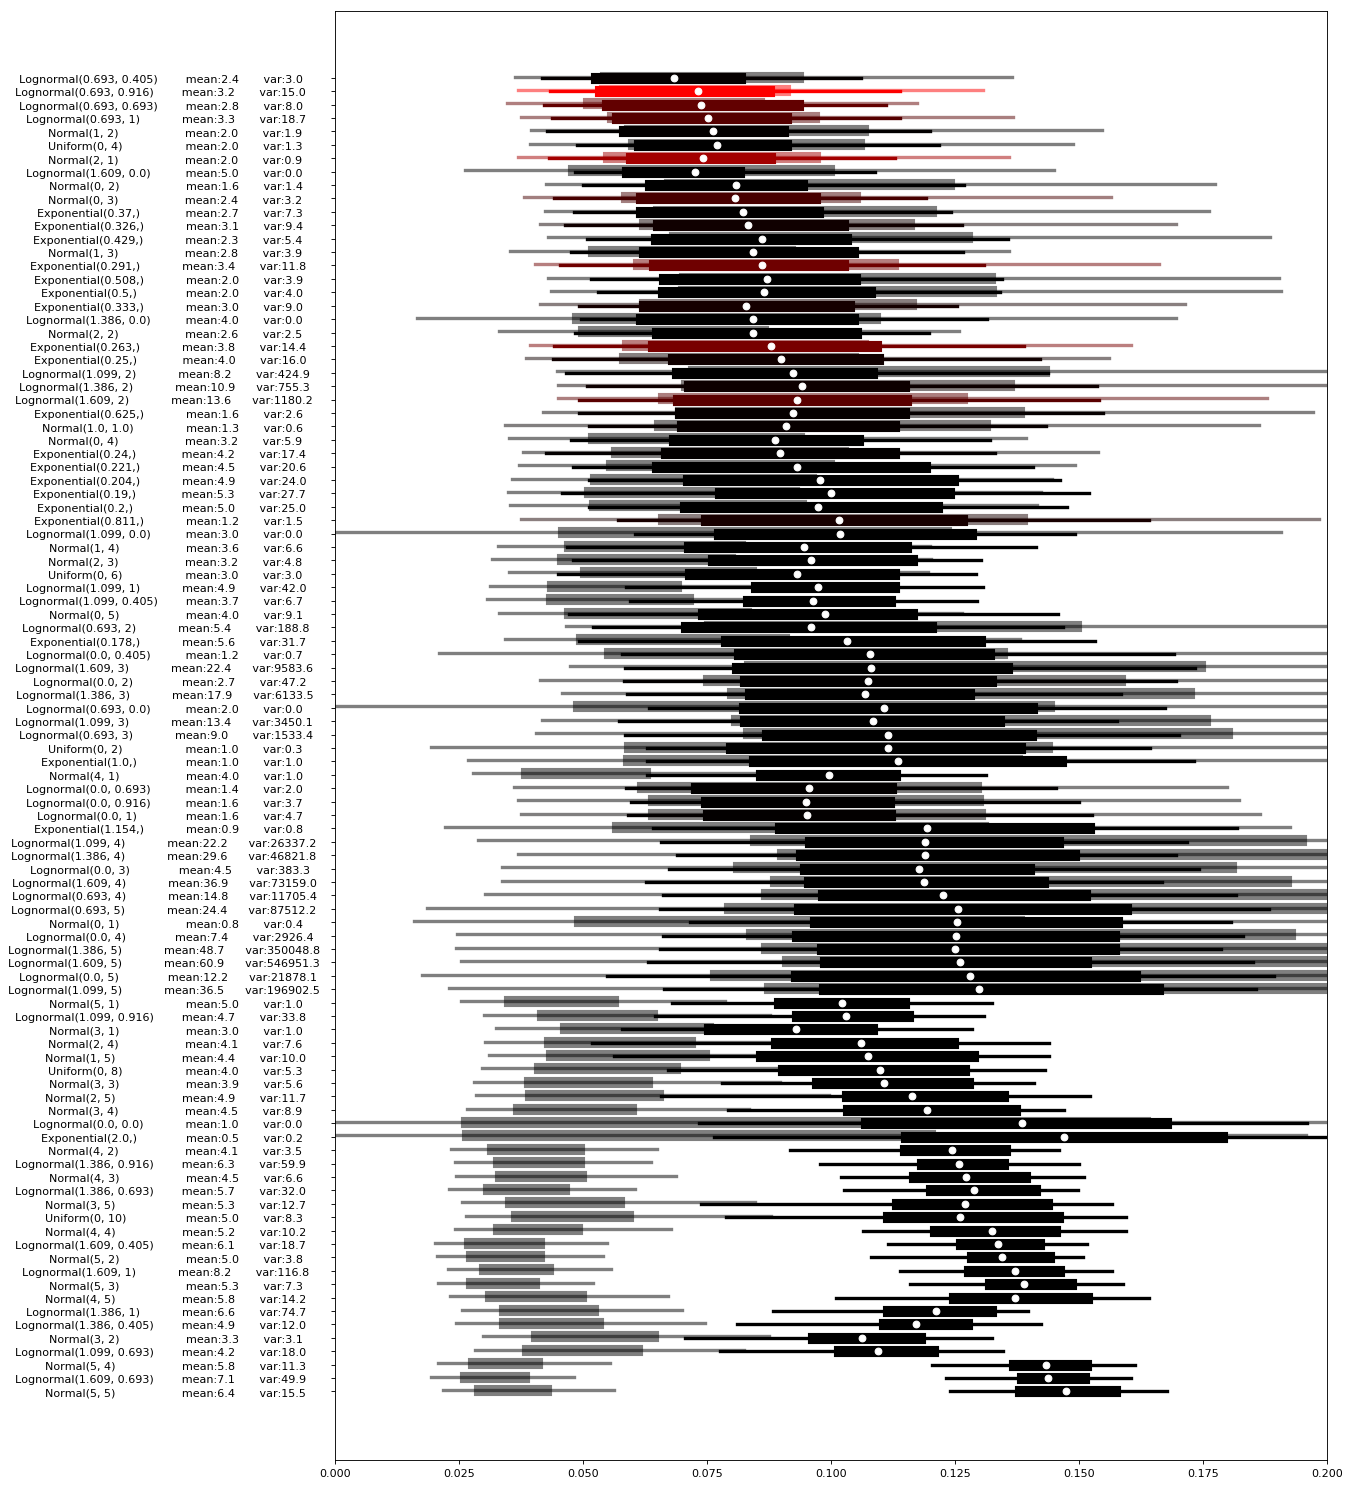

In [16]:
def gen_list(docon):
    lista=[]
    i=0
    for d in docon:
        lista.append(gmean(list(docon[d].values())))
    return lista


def rangesin(floatin):
    return 1-(1-floatin)**3
    if floatin>0.1:
        return 1
    return 0

dict_funs_r={"Exponential":"random.expovariate", "Normal":"random.normalvariate", "Lognormal":"random.lognormvariate"}

j=1
ticks=[]
tlabels=[]
figure(num=None, figsize=(16, 24), dpi=80, facecolor='w', edgecolor='k')


for i in neworder:
    j=j-1
    ticks.append(j)
    lista1=df.iloc[i]["todos"]
    lista_interna=df.iloc[i]["todos_mutual"]
    kst=ks_2samp(lista1, lista_interna)
    label=df.iloc[i]["Fun"]
    label+=str(tuple([round(k, 3) for k in eval(df.iloc[i]["params"])]))
    spacs=np.max([30-len(label), 0])
    spacs="".join([" " for k in range(spacs)])
    label+=spacs+" mean:"+str(round(df.iloc[i]["mean"], 1))
    spacs=np.max([45-len(label), 0])
    spacs="".join([" " for k in range(spacs)])
    label+=spacs+" var:"+str(round(df.iloc[i]["varianza"], 1))
    spacs=np.max([60-len(label), 0])
    spacs="".join([" " for k in range(spacs)])
    label+=spacs
    tlabels.append(label)
    plt.scatter( df.iloc[i]["areas_mean"], j ,  color="white", zorder=10)
    plt.plot([df.iloc[i]["p5"],df.iloc[i]["p95"]], [j,j], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=3)
    plt.plot([df.iloc[i]["p25"],df.iloc[i]["p75"]], [j,j], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=10)
    plt.plot([df.iloc[i]["p5_mutual"],df.iloc[i]["p95_mutual"]], [j+0.1,j+0.1], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=3, alpha=0.5)
    plt.plot([df.iloc[i]["p25_mutual"],df.iloc[i]["p75_mutual"]], [j+0.1,j+0.1], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=10, alpha=0.5)

        
    
    
s=plt.yticks(ticks, tlabels)
s=plt.xlim(0,0.2)


In [20]:
import statsmodels.api as sm

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.8108108108108107}, "d2":d2}


/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


IndexError: cannot do a non-empty take from an empty axes.

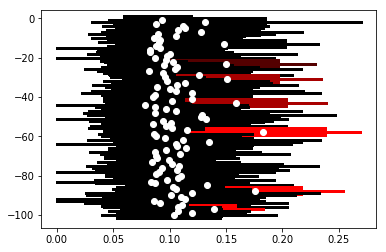

In [46]:
def rangesin3(floatin):
    if floatin<0.01:
        return 1
    if floatin<0.05:
        return 0.66
    if floatin<0.1:
        return 0.33
    return 0

i=0
for a in generic_task:
    print(a)
    print(str(i)+"/"+str(len(generic_task)), end="          \r")
    i+=1
    conn=get_connection()
    with conn.cursor() as cursor:
        sql="select * from tasks_abejas where task_params like \""+a.replace("\"", "\\\"")+"\""
        cursor.execute(sql)
        aa = cursor.fetchall()
    lista_difs=[str(aaa["task_id"]) for aaa in aa]
    condit="("+", ".join(lista_difs)+")"
    with conn.cursor() as cursor:
        sql="select * from distancias_geom where ca in "+condit+"  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
        
        
    with conn.cursor() as cursor:
        sql="select * from distancias_geom where ca=0  and cb in "+condit
        cursor.execute(sql)
        d2 = cursor.fetchall()
        
    conn.close()
    
    df=pd.DataFrame(aa)
    curvas=list(set(list(df["ca"])+list(df["cb"])))
    df2=pd.DataFrame(d2)
    j=0
    for curva in curvas:
        print(j, end="       \r")
        j=j-1
        lista=[]
        mena=np.mean(list(df[(df.ca==curva) | (df.cb==curva) ]["distancia"]))
        p25=np.percentile(list(df[(df.ca==curva) | (df.cb==curva) ]["distancia"]), 25)
        p5=np.percentile(list(df[(df.ca==curva) | (df.cb==curva) ]["distancia"]), 25)
        
        lista=[]
        lista25=[]
        lista5=[]
        for c in curvas:
            
            if c!=curva:
                lista.append(np.mean(list(df[((df.ca==c) | (df.cb==c)) & ((df.ca!=curva) | (df.cb!=curva)) ]["distancia"])))
                lista25.append(np.percentile(list(df[((df.ca==c) | (df.cb==c)) & ((df.ca!=curva) | (df.cb!=curva)) ]["distancia"]), 25))
                lista5.append(np.percentile(list(df[((df.ca==c) | (df.cb==c)) & ((df.ca!=curva) | (df.cb!=curva)) ]["distancia"]), 5))
        
        kst=ks_2samp(lista, [mena])
        
        X = [0 for k in range(len(lista))]+[1]
        y = lista25+[p25]
        X2 = sm.add_constant(X)
        # Note the difference in argument order

        model = sm.OLS(y, np.array(X2)).fit()


        aa=model.pvalues[1]
    
        lista=list(df[(df.ca==curva) | (df.cb==curva)]["distancia"])
        
        plt.scatter( np.mean(lista), j ,  color="white", zorder=10)
        plt.plot([np.percentile(lista, 5), np.percentile(lista, 95)], [j,j], '-', color=(rangesin3(aa), 0,0), linewidth=3)
        plt.plot([np.percentile(lista, 25), np.percentile(lista, 75)], [j,j], '-', color=(rangesin3(aa), 0,0), linewidth=10)
    
    j=j-10
    lista=[]
    lista5=[]
    lista25=[]
    for c in curvas:
        lista.append(np.mean(list(df2[((df.ca==0) | (df.cb==c)) ]["distancia"])))
        lista5.append(np.percentile(list(df2[((df.ca==0) | (df.cb==c)) ]["distancia"]), 5))
        lista25.append(np.percentile(list(df2[((df.ca==0) | (df.cb==c)) ]["distancia"]), 25))

    mena=df2.distancia.mean()
    p5=np.percentile(df2.distancia, 5)
    p25=np.percentile(df2.distancia, 25)
        
    X = [0 for k in range(len(lista))]+[1]
    y = lista25+[p25]
    X2 = sm.add_constant(X)
    # Note the difference in argument order

    model = sm.OLS(y, np.array(X2)).fit()


    aa=model.pvalues[1]

    lista=df2["distancia"]

    plt.scatter( np.mean(lista), j ,  color="white", zorder=10)
    plt.plot([np.percentile(lista, 5), np.percentile(lista, 95)], [j,j], '-', color=(rangesin3(aa), 0,0), linewidth=3)
    plt.plot([np.percentile(lista, 25), np.percentile(lista, 75)], [j,j], '-', color=(rangesin3(aa), 0,0), linewidth=10)
    
    
    
    plt.show()
    



In [45]:
mena

0.06903277142857144

In [30]:
model.pvalues[1]

0.4383608395735712

In [135]:
%run libreria.py
def get_task(ip_address, tas=0):
    if tas==0:
        connection = get_connection()

        with connection.cursor() as cursor:
            sql = "LOCK TABLE tasks_abejas WRITE;" 
            cursor.execute(sql)
        connection.commit()

        with connection.cursor() as cursor:
            sql = "select * from tasks_abejas where task_completed=0 and task_responsible=\"\" order by RAND() limit 1000;" 
            cursor.execute(sql)
            result = cursor.fetchall()
            if result:
                tids=[str(res["task_id"]) for res in result]
                sql = "update tasks_abejas set task_responsible=\""+str(ip_address)+"\" where task_id in ("+", ".join(tids)+")"
                cursor.execute(sql)
            else:
                sql = "select * from tasks_abejas where task_completed=0 order by RAND() limit 1;" 
                cursor.execute(sql)
                result = cursor.fetchone()
                result=[result]
                if not result:
                    result=False
        connection.commit()

        with connection.cursor() as cursor:
            sql = "UNLOCK TABLES;" 
            cursor.execute(sql)

        connection.commit()
        connection.close()
        return result
    else:
        connection = get_connection()

    

        with connection.cursor() as cursor:
            sql = "select * from tasks_abejas where task_id="+str(tas) 
            cursor.execute(sql)
            result = cursor.fetchall()
        connection.close()
        return result

In [136]:
r=get_task(0, 40097)

In [137]:
r

[{'task_id': 40097,
  'task_name': 'montecarlobees',
  'task_params': '{"num_familias":269, "num_abejas":3000, "bootstrap":93, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":3}, "d2":d2}',
  'task_completed': 1575070825,
  'task_responsible': '3.134.243.34',
  'progress': '0'}]

NameError: name 'dict_res' is not defined

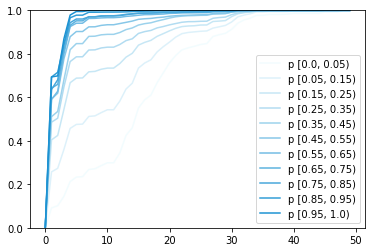

In [154]:
import random
import requests
from urllib.request import urlopen
from multiprocessing import Manager
import time


external_ip = urlopen('https://ident.me').read().decode('utf8')

d2=get_d2()

f=open("diccionario_distfisica_v_distgenetica.txt", "r")
diccionario_distfisica_v_distgenetica=eval(f.read())
f.close()


%run libreria.py
import time

s=eval(r[0]["task_name"])(**eval(r[0]["task_params"]), tid=r[0]["task_id"], makeplot=True)




In [ ]:
s

In [ ]:
l

In [156]:
generic_task

['{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":2}, "d2":d2}',
 '{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":2.0}, "d2":d2}',
 '{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.5}, "d2":d2}',
 '{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":1}, "d2":d2}',
 '{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.0}, "d2":d2}',
 '{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":2}, "d2":d2}',
 '{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":2}, "d2":d2}',
 '{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.17751479289940827}, "d2":d2}',
 '{"num_familias":26

In [158]:
distancias_mutuas={}
distancias_origen={}

i=0
for a in generic_task[1:2]:
    print(str(i)+"/"+str(len(generic_task)), end="          \r")
    i+=1
    conn=get_connection()
    with conn.cursor() as cursor:
        sql="select * from tasks_abejas where task_params like \""+a.replace("\"", "\\\"")+"\""
        cursor.execute(sql)
        aa = cursor.fetchall()
    lista_difs=[str(aaa["task_id"]) for aaa in aa]
    condit="("+", ".join(lista_difs)+")"
    with conn.cursor() as cursor:
        sql="select * from distancias_geom where ca in "+condit+"  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
    conn.close()

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":2}, "d2":d2}


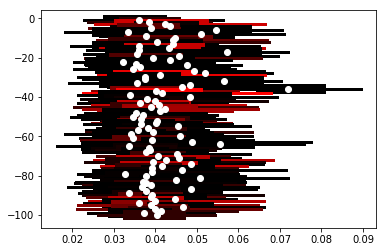

0.9967562532276265


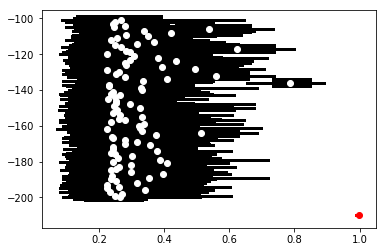

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":2.0}, "d2":d2}


0.6117764105154835


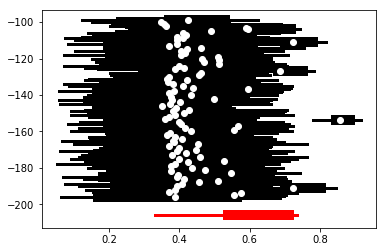

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.5}, "d2":d2}


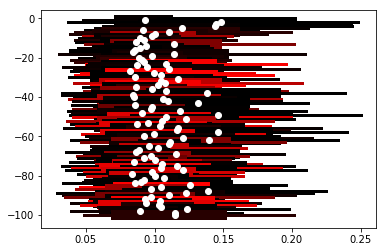

0.258012171366516


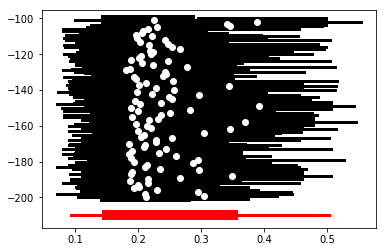

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":1}, "d2":d2}


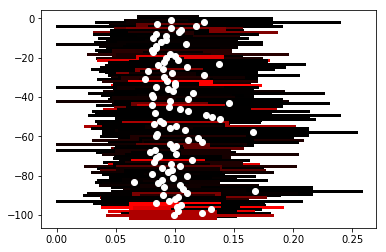

0.27729163292116166


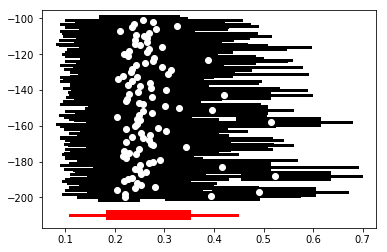

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.0}, "d2":d2}


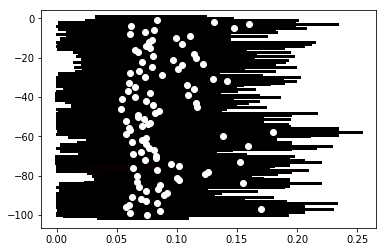

0.4193453686082368


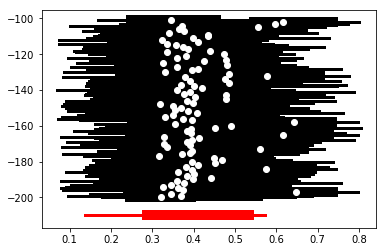

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":2}, "d2":d2}


0.8420434549577407


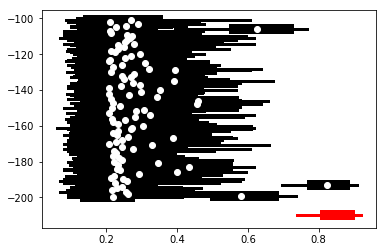

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":2}, "d2":d2}


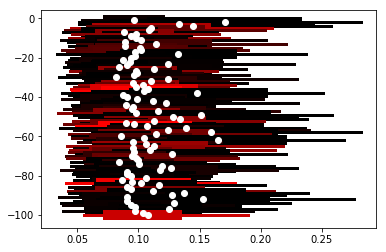

0.20606043020144643


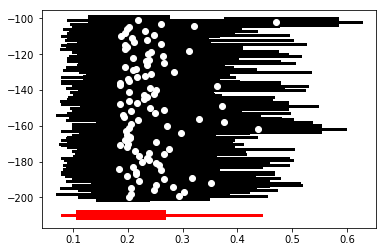

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.17751479289940827}, "d2":d2}


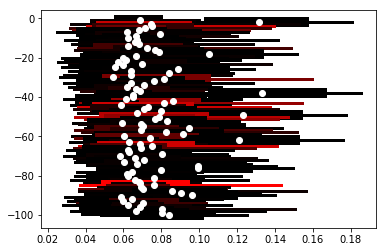

0.47226379681519587


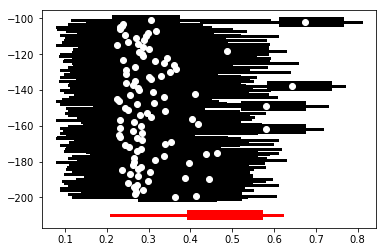

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.3333333333333333}, "d2":d2}


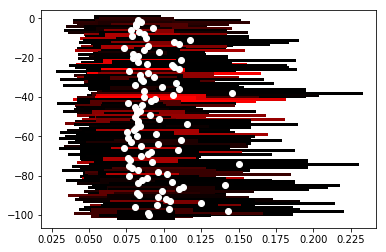

0.21519853489662033


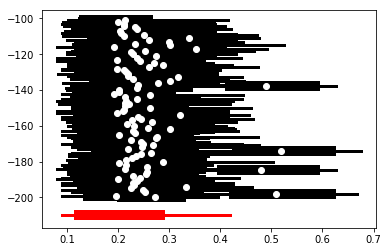

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":1}, "d2":d2}


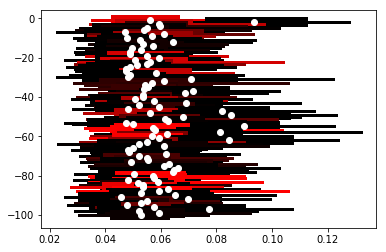

0.6839115486869537


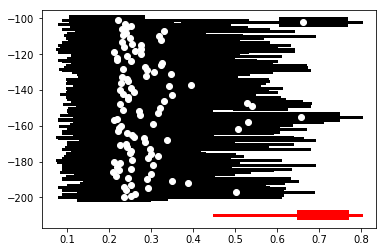

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":4}, "d2":d2}


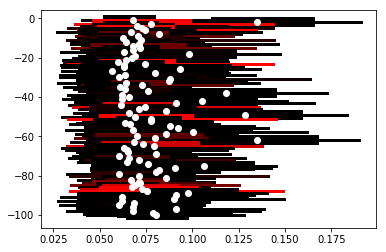

0.3535434769002883


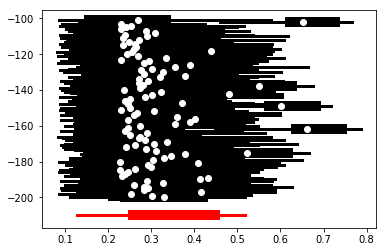

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":4}, "d2":d2}


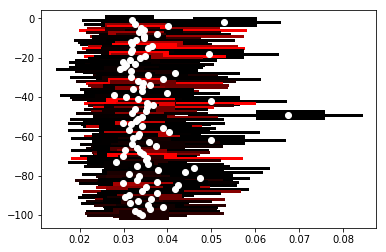

0.9997979797979798


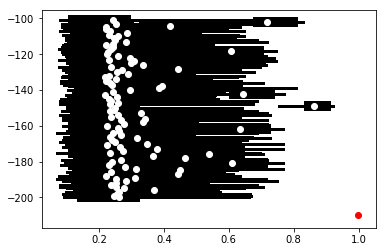

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":6}, "d2":d2}


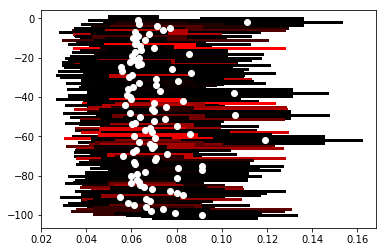

0.4521525364628826


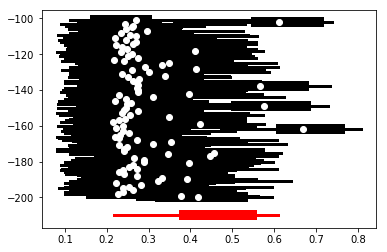

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":1}, "d2":d2}


1.0


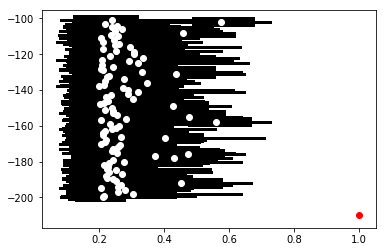

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":3}, "d2":d2}


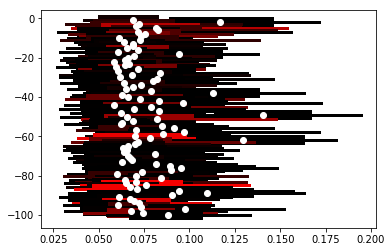

0.29733615345544656


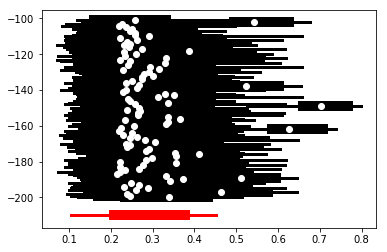

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":5}, "d2":d2}


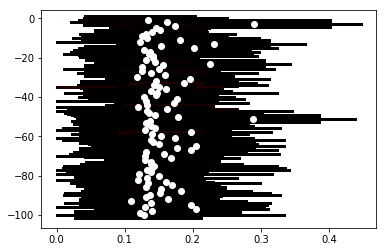

0.3378933241525289


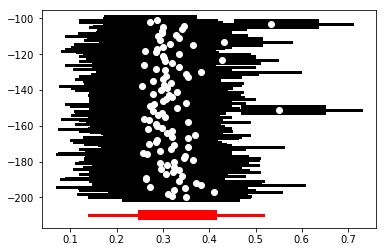

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":5}, "d2":d2}


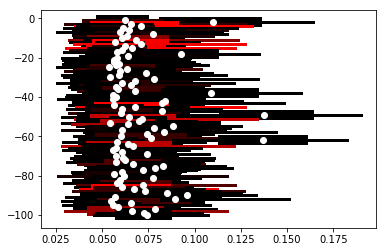

0.5096916964276627


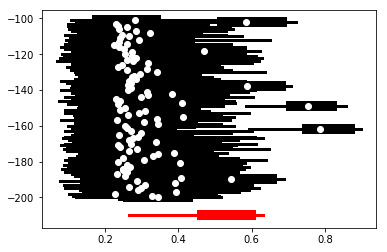

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":5}, "d2":d2}


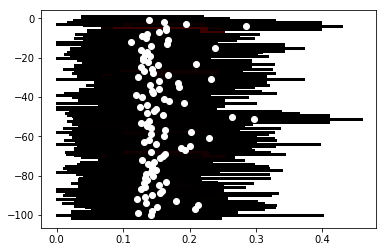

0.3448957464397818


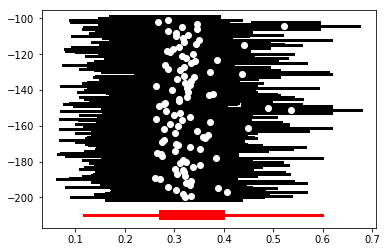

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":5}, "d2":d2}


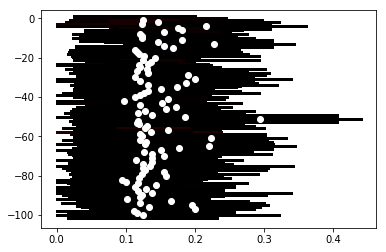

0.34124190059653975


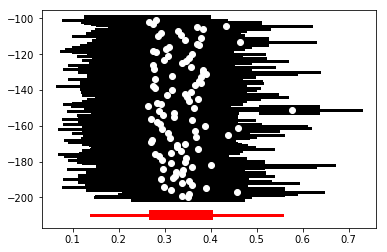

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":2}, "d2":d2}


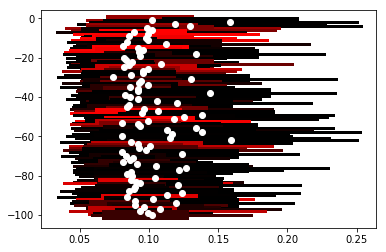

0.2072717996289425


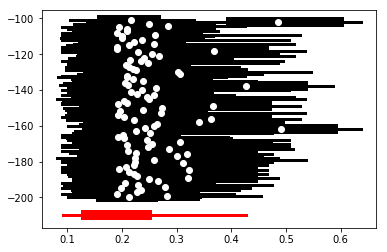

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":4}, "d2":d2}


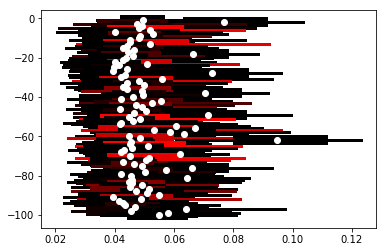

0.9100151676665668


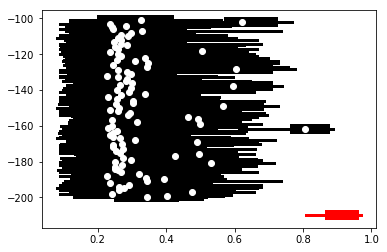

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.2040816326530612}, "d2":d2}


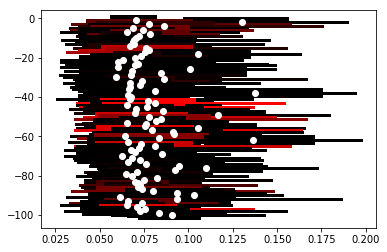

0.37325966308891556


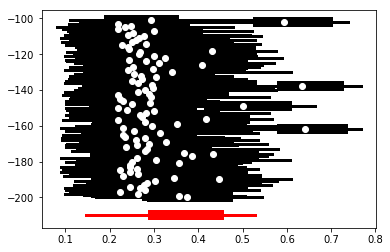

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.0}, "d2":d2}


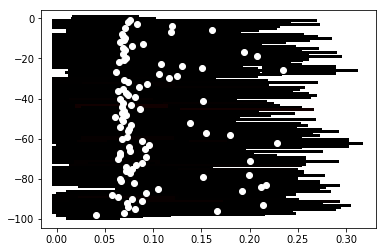

0.6059969624400636


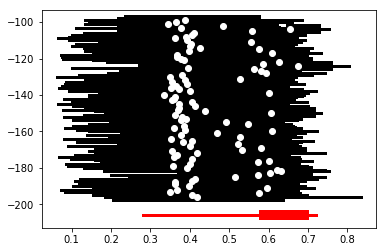

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":5}, "d2":d2}


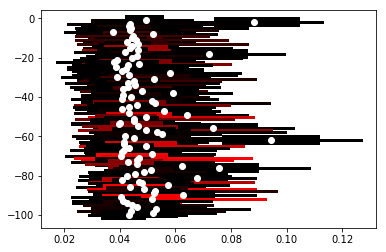

0.9152301491668209


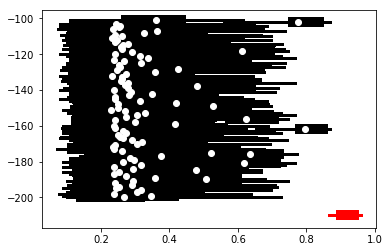

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":4}, "d2":d2}


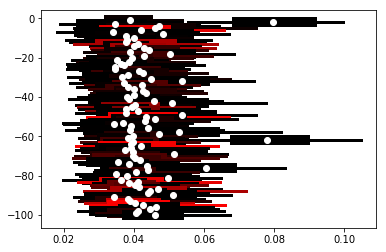

0.9805489944150105


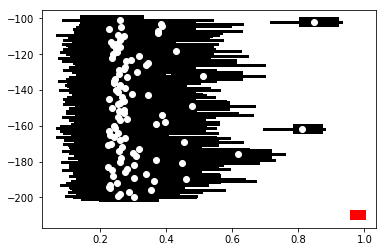

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":5}, "d2":d2}


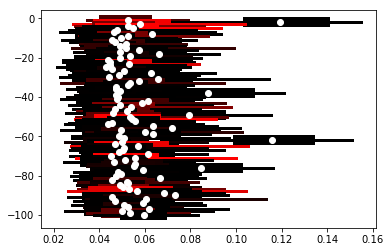

0.8067273200657956


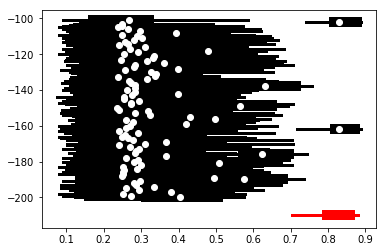

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.22058823529411764}, "d2":d2}


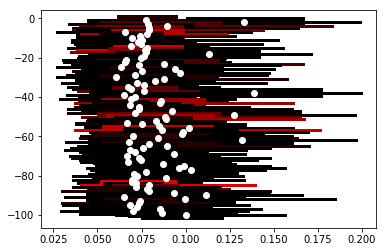

0.30123302985674116


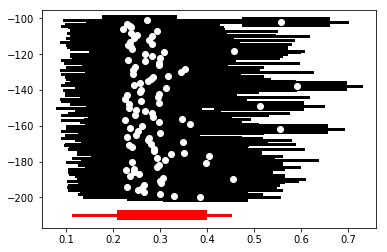

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.609, "sigma":0.693}, "d2":d2}


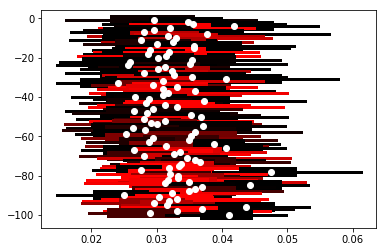

1.0


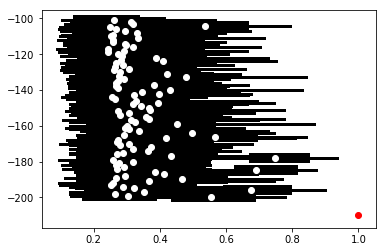

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":4}, "d2":d2}


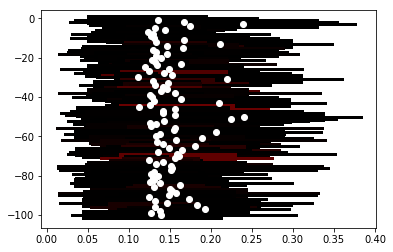

0.33192326428072005


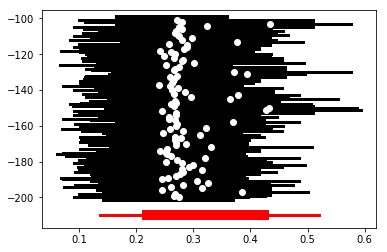

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.405}, "d2":d2}


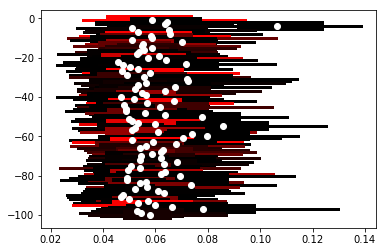

0.6574815387198304


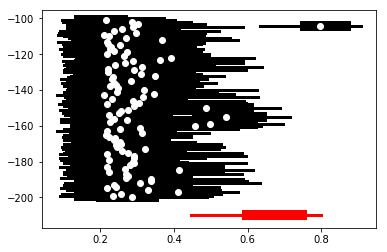

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":2}, "d2":d2}


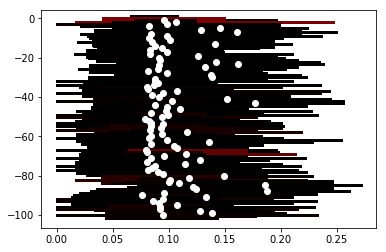

0.3492743511806473


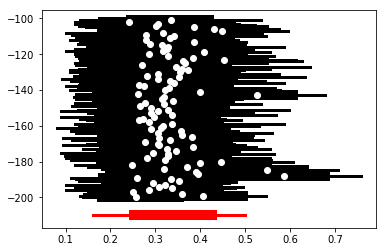

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":3}, "d2":d2}


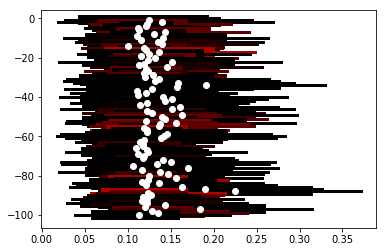

0.29970438935961763


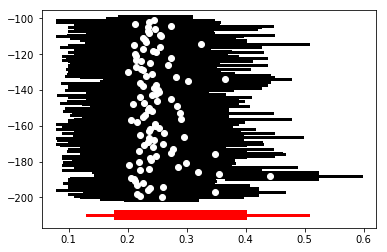

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":4}, "d2":d2}


0.6899093282923916


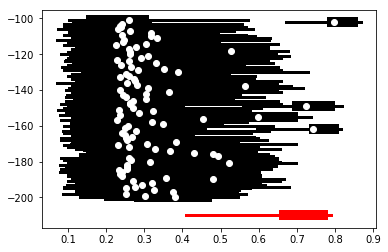

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":1}, "d2":d2}


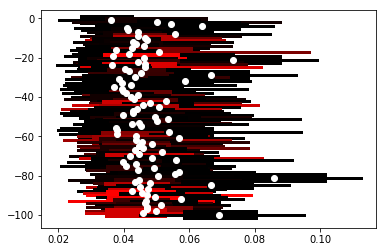

0.8771745130667074


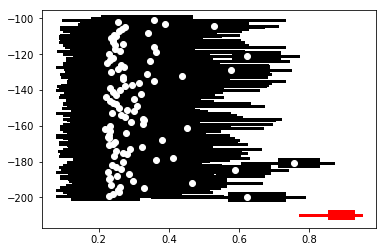

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.386, "sigma":0.916}, "d2":d2}


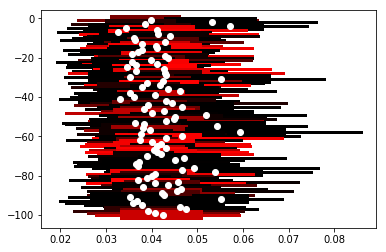

0.9987939187796332


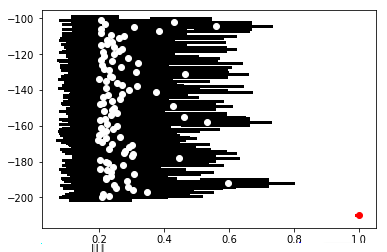

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.625}, "d2":d2}


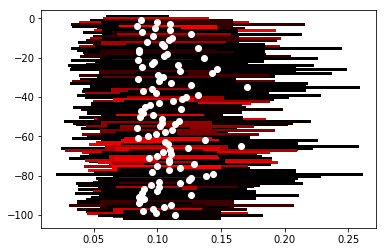

0.23643724771383096


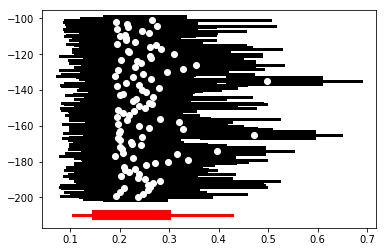

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":2}, "d2":d2}


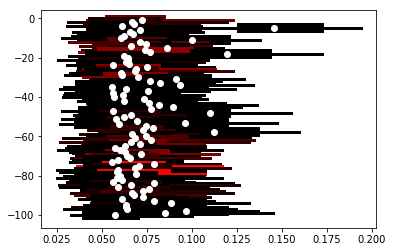

0.35479074417645856


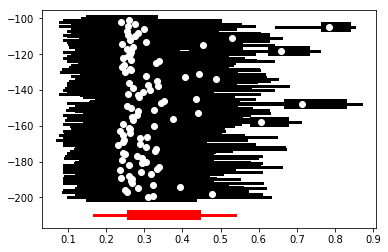

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":3}, "d2":d2}


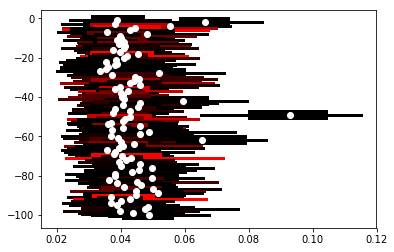

0.9743887645654952


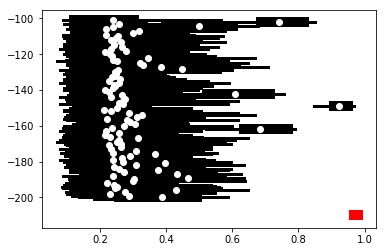

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.916}, "d2":d2}


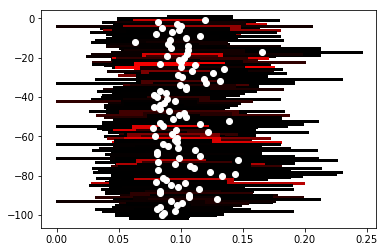

0.29457054236877506


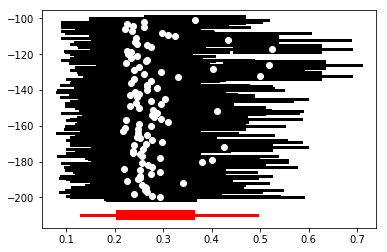

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":2}, "d2":d2}


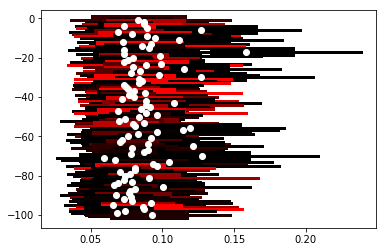

0.23541878685869846


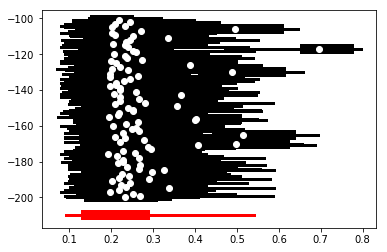

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":3}, "d2":d2}


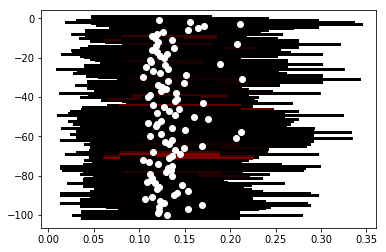

0.2975216728195016


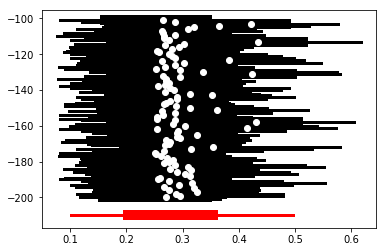

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":3}, "d2":d2}


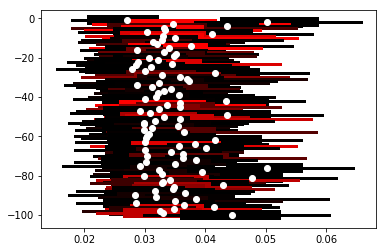

1.0


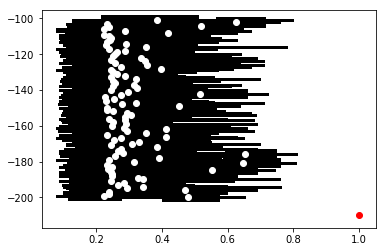

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.693, "sigma":0.693}, "d2":d2}


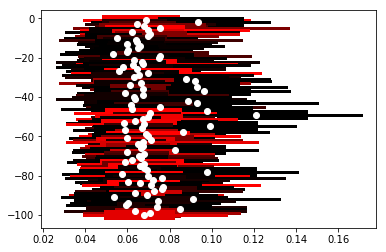

0.2333379813281139


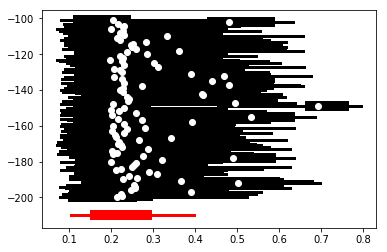

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.693}, "d2":d2}


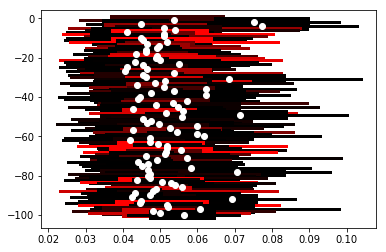

0.9054110641444957


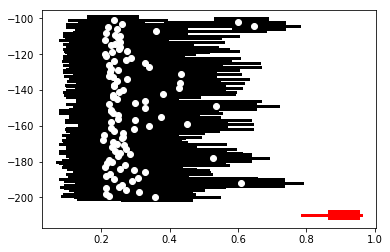

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":5}, "d2":d2}


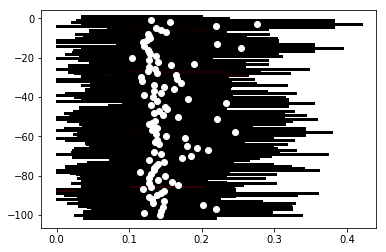

0.3421234677938654


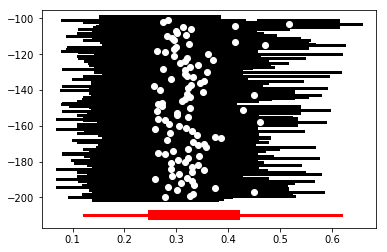

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.25}, "d2":d2}


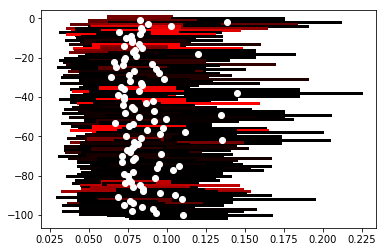

0.25821604388084507


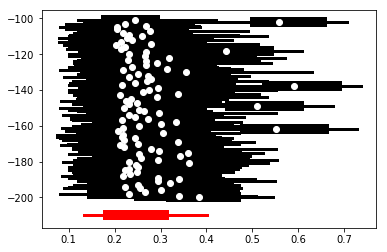

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":4}, "d2":d2}


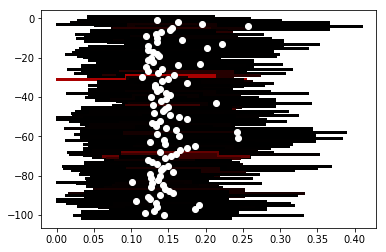

0.3164066690468752


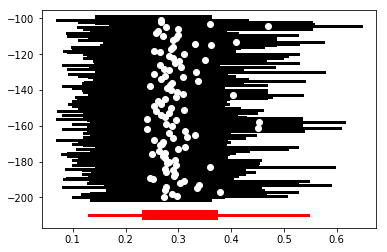

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":3}, "d2":d2}


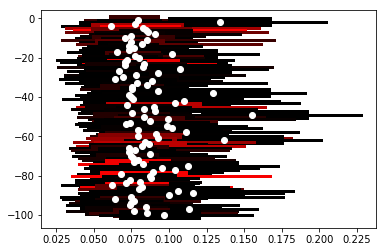

0.241249815852614


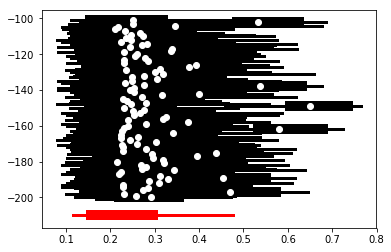

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.405}, "d2":d2}


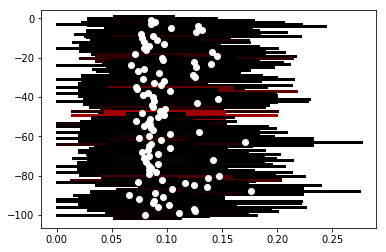

0.3626995960020997


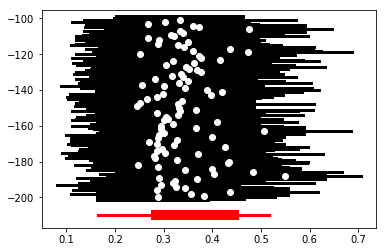

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":1.0}, "d2":d2}


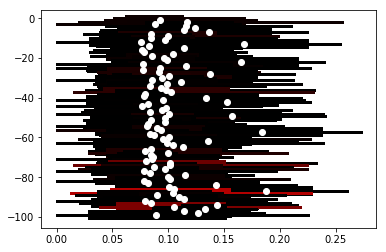

0.334339906185479


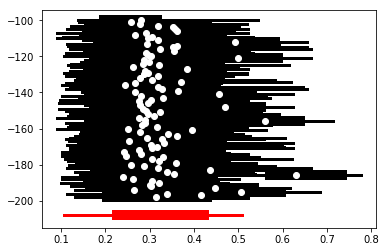

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":3}, "d2":d2}


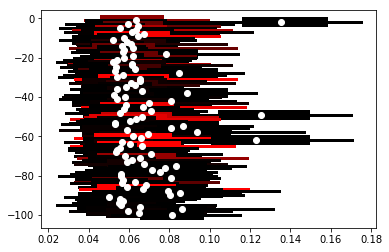

0.5448916879716585


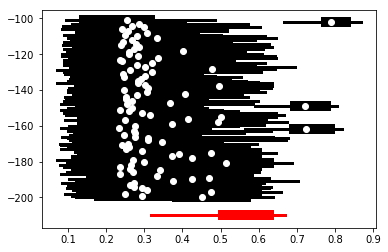

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.693}, "d2":d2}


0.28654021681149816


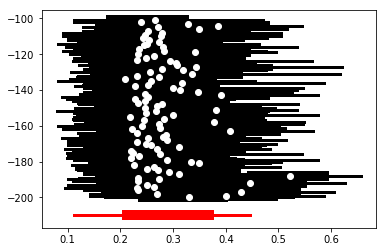

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":1}, "d2":d2}


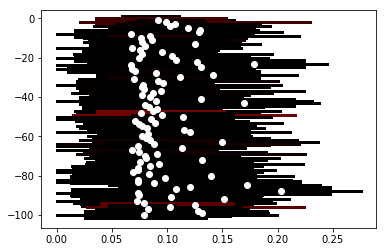

0.436030502133687


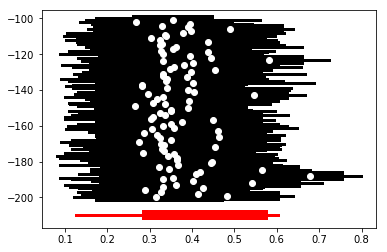

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":3}, "d2":d2}


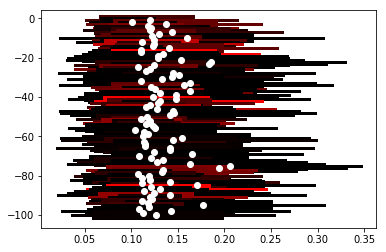

0.28705427369635766


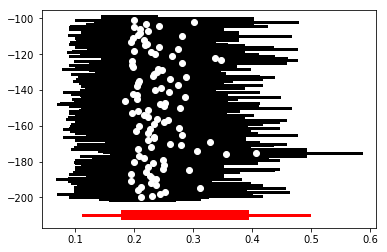

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.609, "sigma":0.0}, "d2":d2}


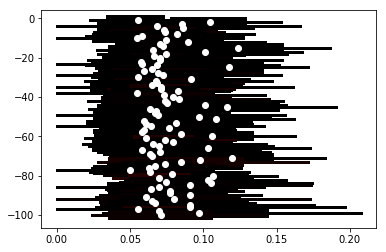

0.3611486675348051


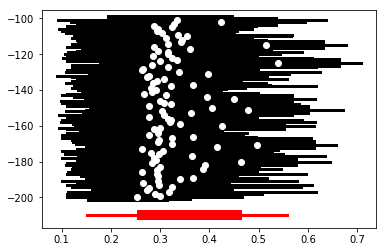

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.189873417721519}, "d2":d2}


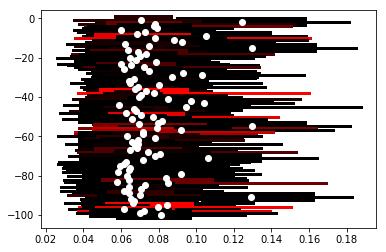

0.428450855281194


{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":3}, "d2":d2}


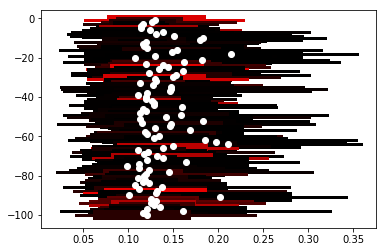

0.2655182079314075


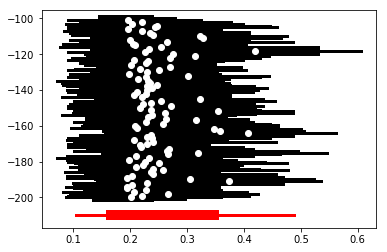

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.2631578947368421}, "d2":d2}


0.2333310225917921


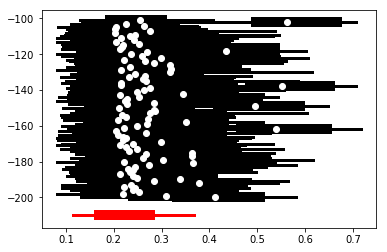

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.8108108108108107}, "d2":d2}


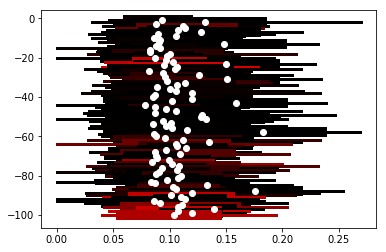

0.2480627303436213


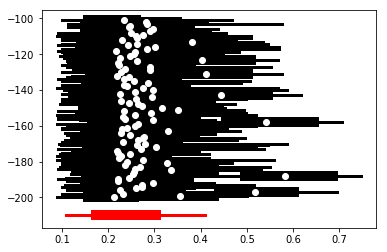

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.37037037037037035}, "d2":d2}


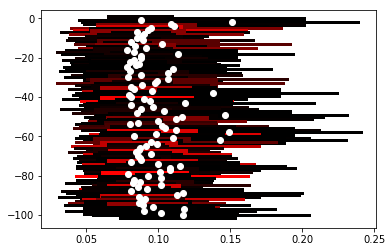

0.2364658355063363


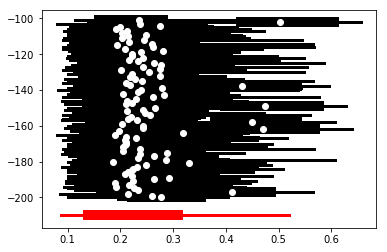

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":1}, "d2":d2}


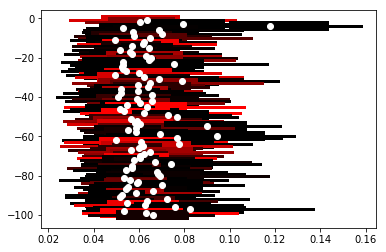

0.5657714595725825


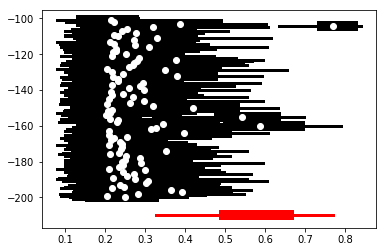

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":8}, "d2":d2}


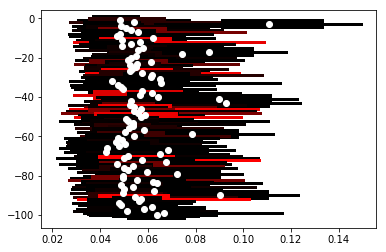

0.765290333377962


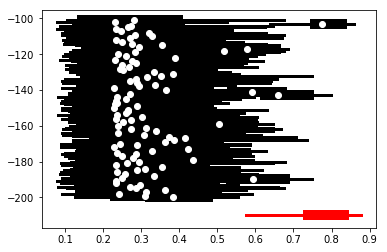

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1.0, "sigma":1.0}, "d2":d2}


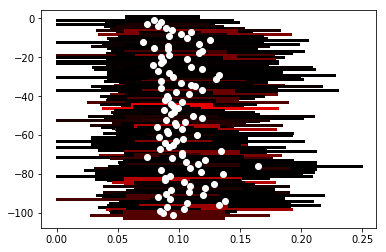

0.2483814184611025


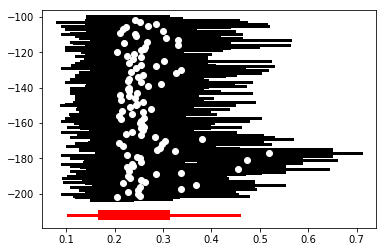

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":1}, "d2":d2}


0.7999298786306152


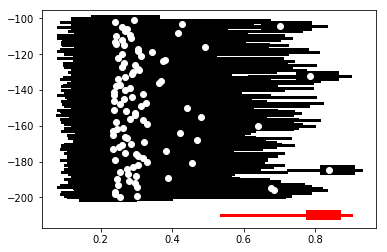

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":5}, "d2":d2}


1.0


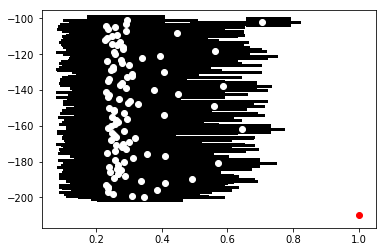

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":1}, "d2":d2}


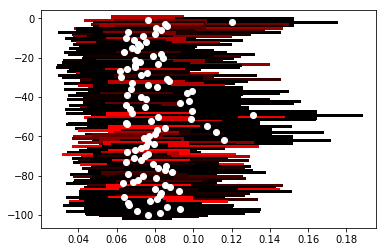

0.22187038701766248


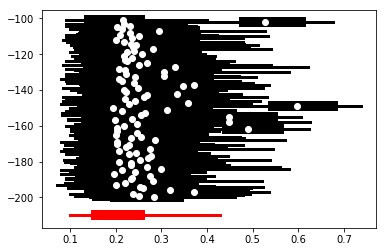

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.916}, "d2":d2}


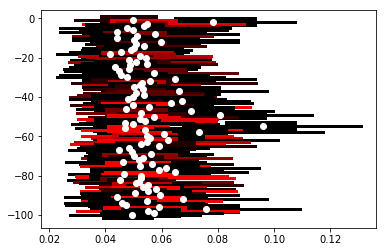

0.8220156541216924


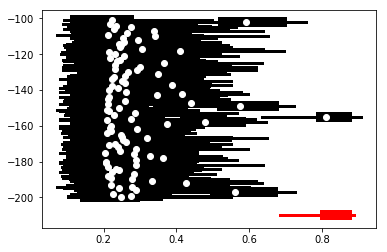

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":4}, "d2":d2}


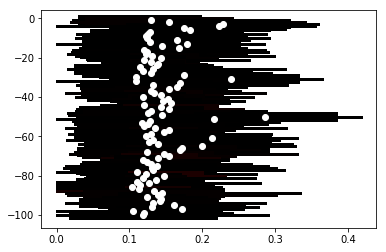

0.31556147944217944


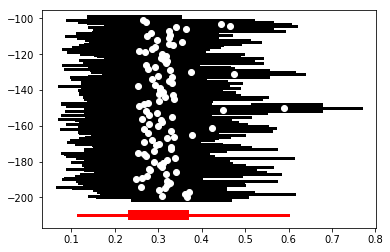

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":2}, "d2":d2}


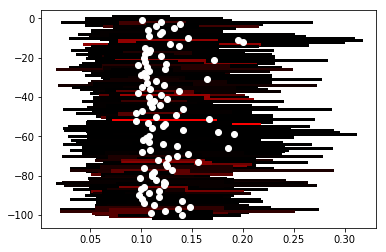

0.2530317976237668


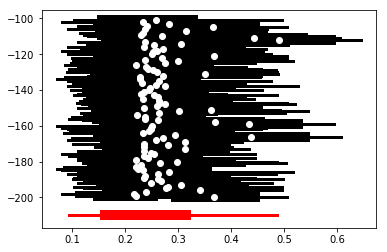

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.32608695652173914}, "d2":d2}


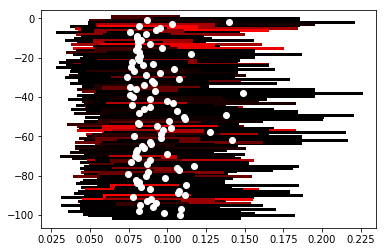

0.21692121743417764


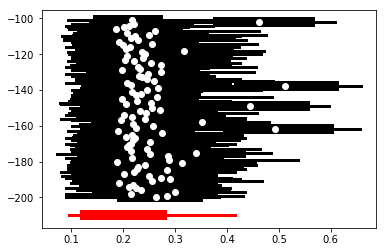

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":3}, "d2":d2}


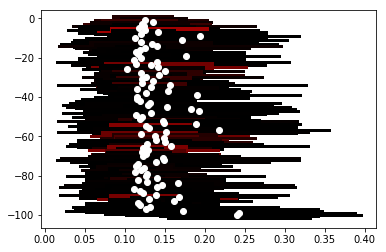

0.2734501548198161


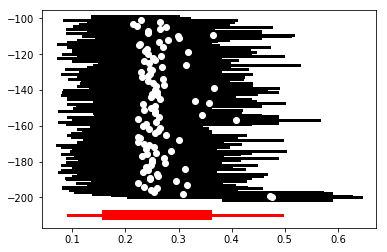

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":5}, "d2":d2}


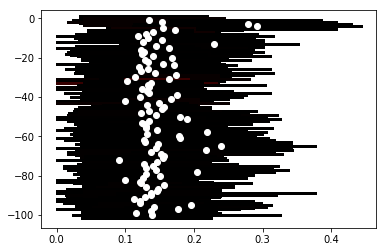

0.3495129181569534


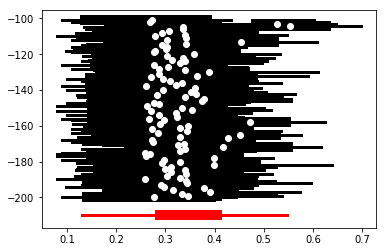

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":4}, "d2":d2}


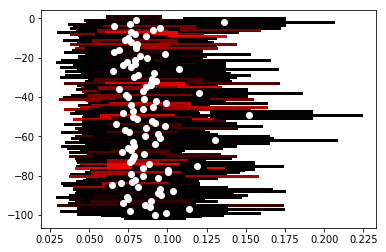

0.2556007219257587


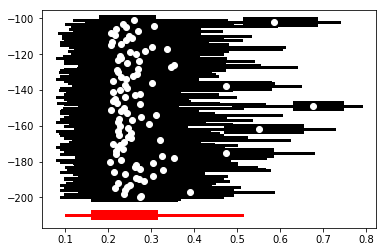

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":10}, "d2":d2}


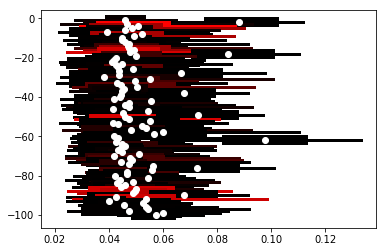

0.9031286739156767


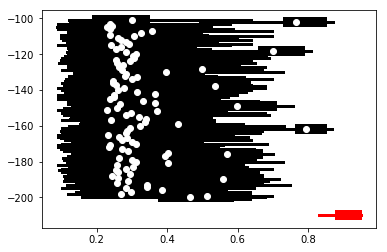

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":3}, "d2":d2}


0.8679569389455252


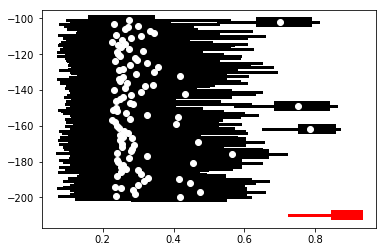

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.24000000000000005}, "d2":d2}


0.2779667697381983


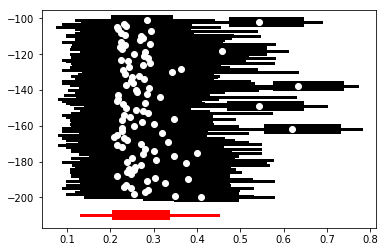

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.29126213592233013}, "d2":d2}


0.21698597589613794


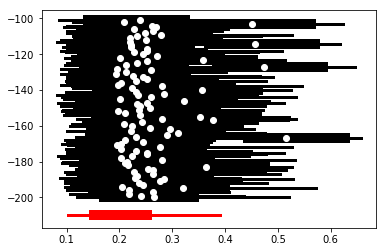

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.693, "sigma":0.916}, "d2":d2}


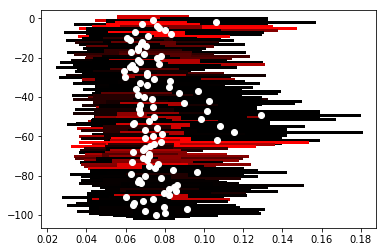

0.20308706675422436


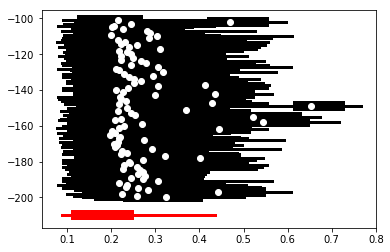

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.693, "sigma":0.405}, "d2":d2}


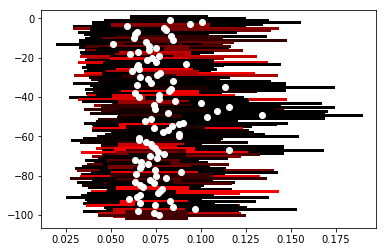

0.23993236794092831


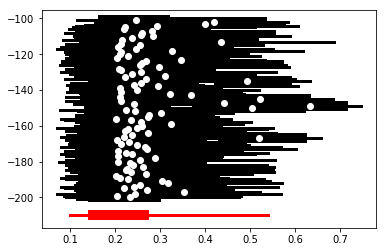

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.609, "sigma":0.405}, "d2":d2}


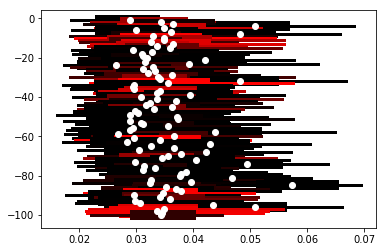

1.0


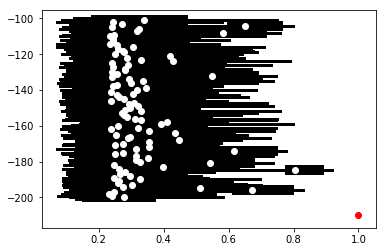

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":1}, "d2":d2}


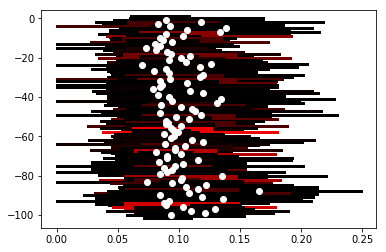

0.2476952034547027


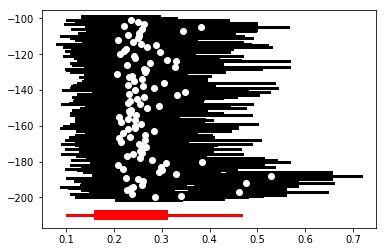

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":1.1538461538461537}, "d2":d2}


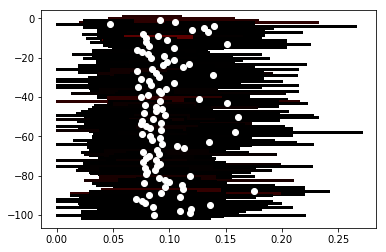

0.3763551827181982


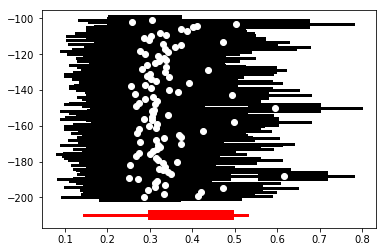

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":4}, "d2":d2}


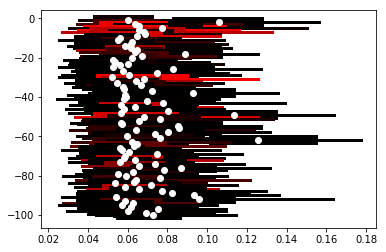

0.47685141866806086


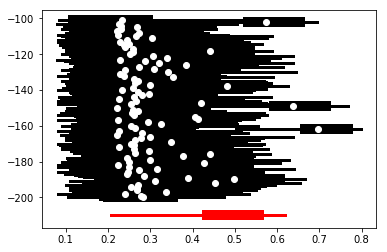

{"num_familias":40, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0, "sigma":1.0}, "d2":d2}


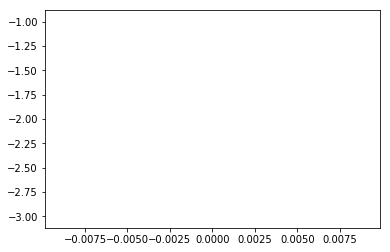

1.0


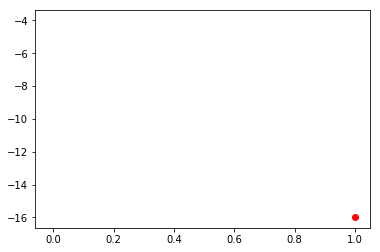

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":5}, "d2":d2}


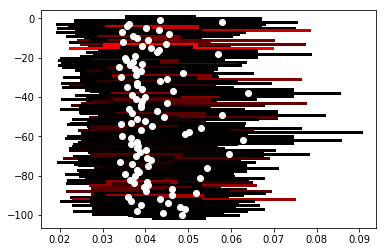

0.9985848278705421


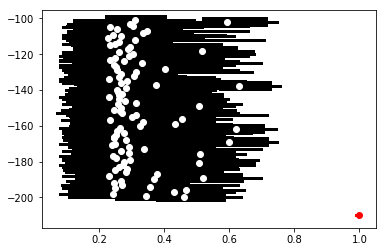

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":1}, "d2":d2}


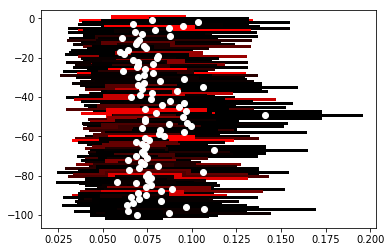

0.22755622158891672


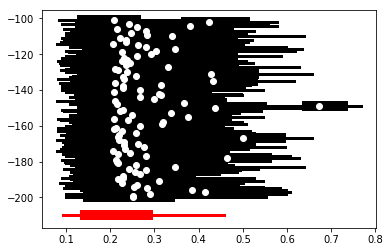

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":2}, "d2":d2}


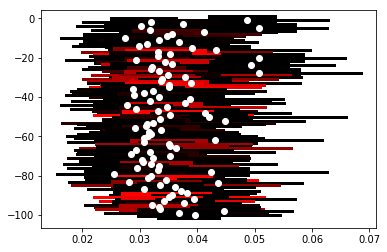

1.0


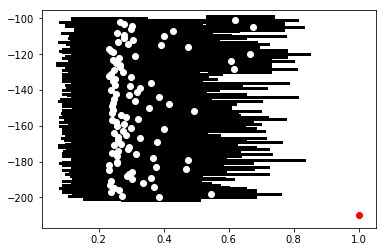

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.5084745762711864}, "d2":d2}


0.24851830837302116


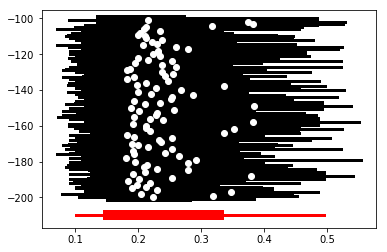

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.2}, "d2":d2}


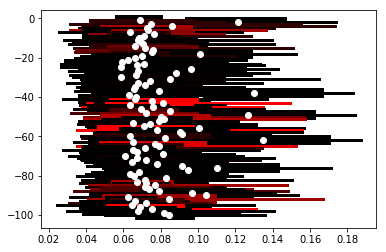

0.3845737116589841


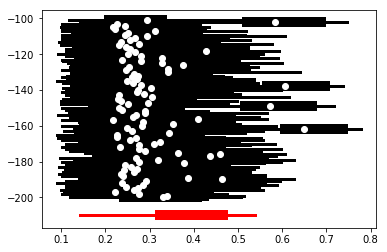

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.4285714285714286}, "d2":d2}


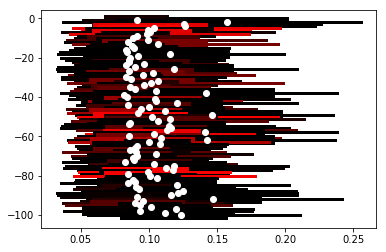

0.24061326966275423


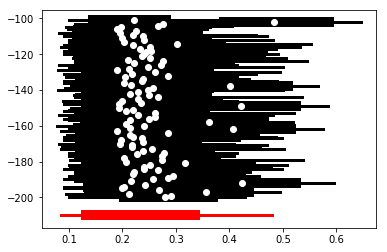

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":1}, "d2":d2}


0.9763953160895724


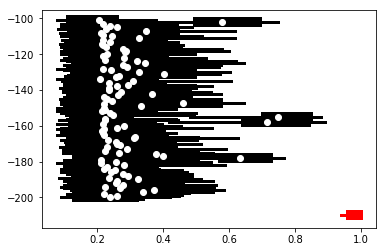

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":2}, "d2":d2}


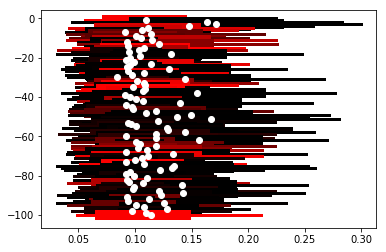

0.24514213898930393


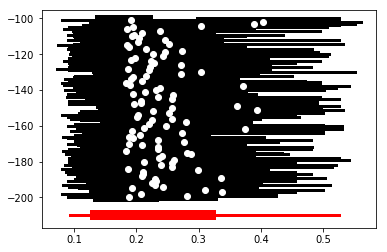

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":5}, "d2":d2}


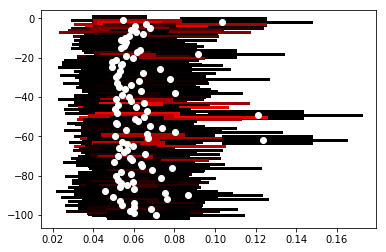

0.6551127479295374


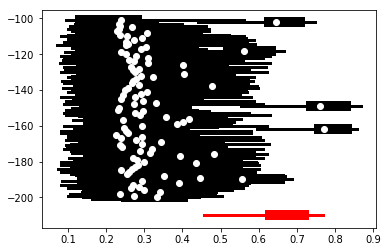

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":4}, "d2":d2}


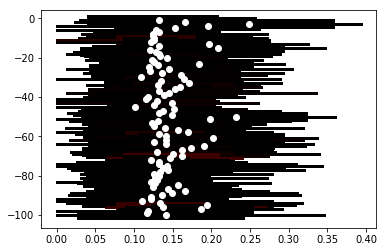

0.3217207386828521


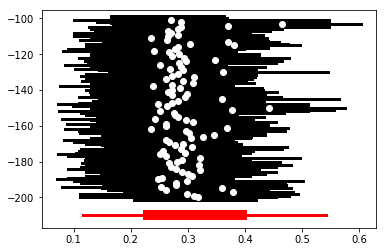

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.386, "sigma":0.0}, "d2":d2}


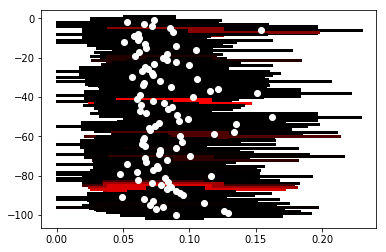

0.3345344887970809


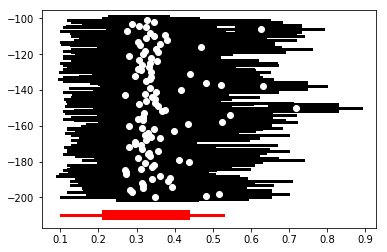

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":2}, "d2":d2}


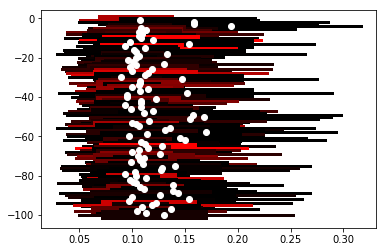

0.25031734599782135


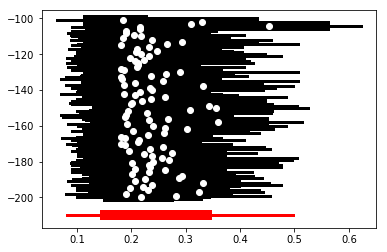

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":2}, "d2":d2}


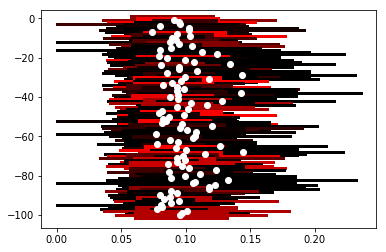

0.28022593917292005


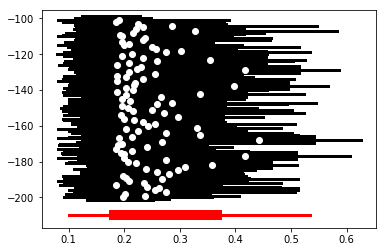

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.386, "sigma":0.405}, "d2":d2}


0.9454246914760905


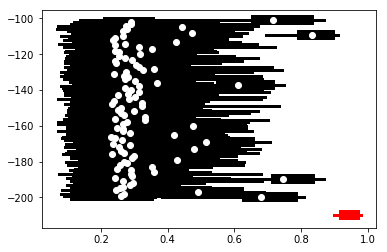

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.386, "sigma":0.693}, "d2":d2}


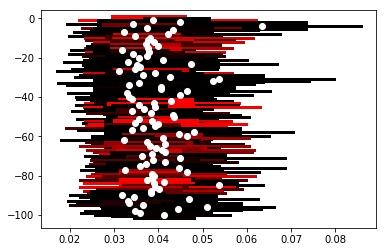

0.9958959389816533


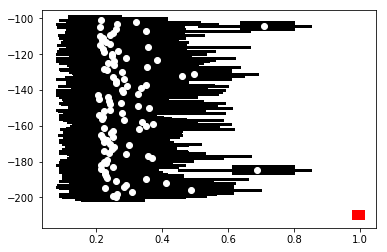

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":4}, "d2":d2}


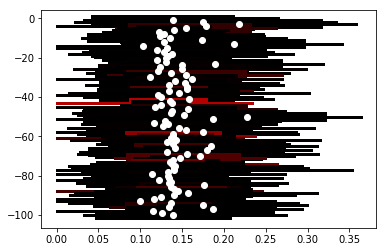

0.3228240745345311


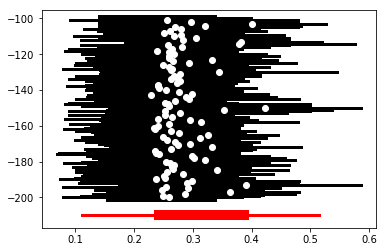

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.693, "sigma":0.0}, "d2":d2}


0.4098245722531438


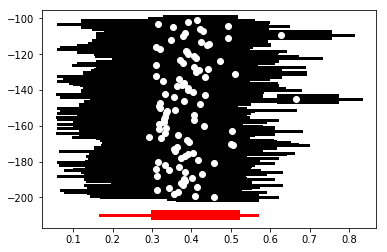

{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.609, "sigma":0.916}, "d2":d2}


KeyError: 'ca'

In [182]:
i=0
for a in generic_task:
    print(a)
    print(str(i)+"/"+str(len(generic_task)), end="          \r")
    i+=1
    conn=get_connection()
    with conn.cursor() as cursor:
        sql="select * from tasks_abejas where task_params like \""+a.replace("\"", "\\\"")+"\""
        cursor.execute(sql)
        aa = cursor.fetchall()
    lista_difs=[str(aaa["task_id"]) for aaa in aa]
    condit="("+", ".join(lista_difs)+")"
    with conn.cursor() as cursor:
        sql="select * from distancias_geom where ca in "+condit+"  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
    conn.close()
    
    df=pd.DataFrame(aa)
    curvas=list(set(list(df["ca"])+list(df["cb"])))
    
    j=0
    for curva in curvas:
        j=j-1
        lista=list(df[(df.ca==curva) | (df.cb==curva)]["distancia"])
        listaor=list(df[(df.ca!=curva) & (df.cb!=curva)]["distancia"])
        kst=ks_2samp(lista, listaor)
        plt.scatter( np.mean(lista), j ,  color="white", zorder=10)
        plt.plot([np.percentile(lista, 5), np.percentile(lista, 95)], [j,j], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=3)
        plt.plot([np.percentile(lista, 25), np.percentile(lista, 75)], [j,j], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=10)
    plt.show() 
    
    for curva in curvas:
        j=j-1
        lista=list(df[(df.ca==curva) | (df.cb==curva)]["distancia"])
        lista3=[]
        for curva2 in curvas:
            if curva2!=curva:
                lista2=list(df[(df.ca==curva2) | (df.cb==curva2)]["distancia"])
                kst=ks_2samp(lista, lista2)
                lista3.append(kst.statistic)
                
            
            
        plt.scatter( np.mean(lista3), j ,  color="white", zorder=10)
        plt.plot([np.percentile(lista3, 5), np.percentile(lista3, 95)], [j,j], '-', color=(0, 0,0), linewidth=3)
        plt.plot([np.percentile(lista3, 25), np.percentile(lista3, 75)], [j,j], '-', color=(0, 0,0), linewidth=10)
    
    conn=get_connection()
    with conn.cursor() as cursor:
        sql="select * from distancias_geom where ca=0  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
    conn.close()
    
    df2=pd.DataFrame(aa)
    j=j-10
    lista=list(df2[df2.ca==0]["distancia"])
    lista3=[]
    for curva2 in curvas:
        lista2=list(df[(df.ca==curva2) | (df.cb==curva2)]["distancia"])
        kst=ks_2samp(lista, lista2)
        if kst.statistic<1000 and kst.statistic>-1000: lista3.append(kst.statistic)


    #plt.scatter( 0.8, j,  color="red", zorder=10)
    plt.scatter( np.mean(lista3), j ,  color="red", zorder=10)
    plt.plot([np.percentile(lista3, 5), np.percentile(lista3, 95)], [j,j], '-', color="red", linewidth=3)
    plt.plot([np.percentile(lista3, 25), np.percentile(lista3, 75)], [j,j], '-', color="red", linewidth=10)

    print(np.mean(lista3))
    plt.show() 
    
    X = [0 for k in range(100)]+[1]
    x1=[0 for k in range(100)]+[1]
    x2=[1 for k in range(101)]
    y = [random.random() for k in range(101)]
    X2 = sm.add_constant(x1)
    # Note the difference in argument order

    model = sm.OLS(y, np.array(X2)).fit()

    
    model.pvalues[1]



{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":2}, "d2":d2}


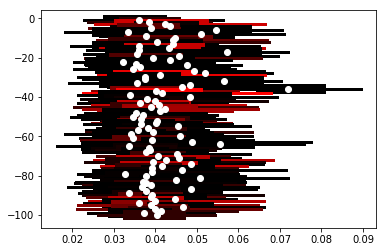

0.9967562532276265


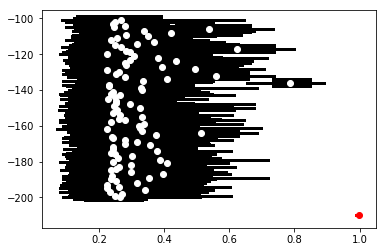

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":2.0}, "d2":d2}


0.6117764105154835


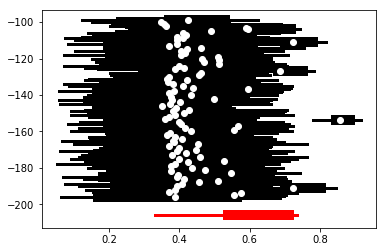

P-val: 0.053
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.5}, "d2":d2}


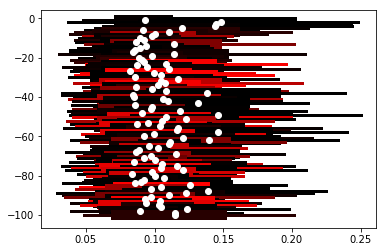

0.258012171366516


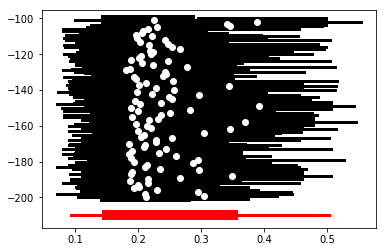

P-val: 0.632
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":1}, "d2":d2}


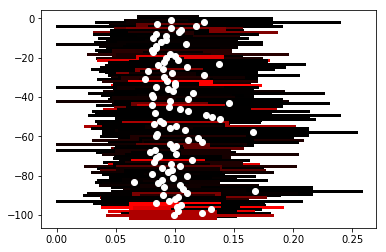

0.27729163292116166


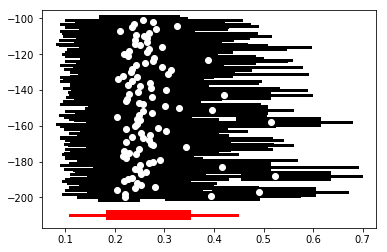

P-val: 0.893
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.0}, "d2":d2}


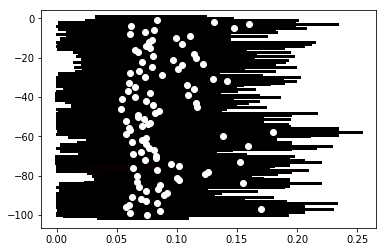

0.4193453686082368


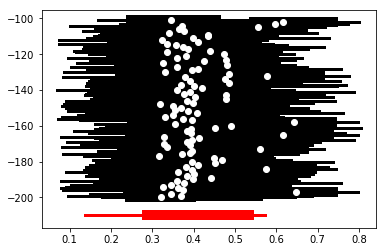

P-val: 0.879
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":2}, "d2":d2}


0.8420434549577407


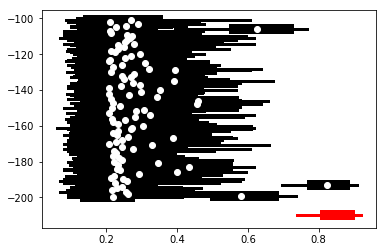

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":2}, "d2":d2}


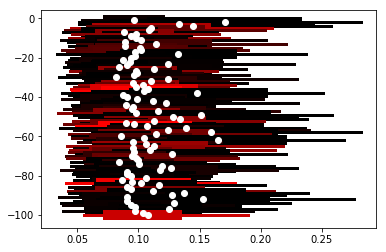

0.20606043020144643


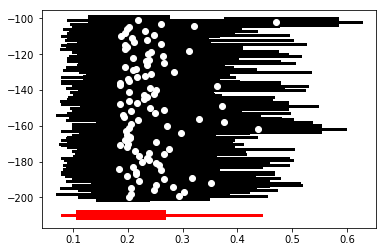

P-val: 0.521
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.17751479289940827}, "d2":d2}


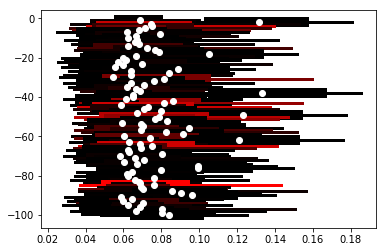

0.47226379681519587


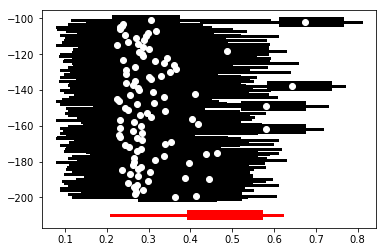

P-val: 0.059
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.3333333333333333}, "d2":d2}


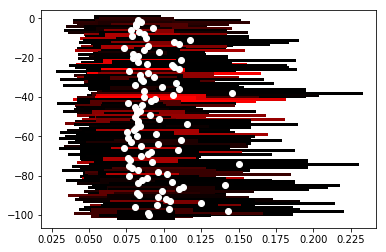

0.21519853489662033


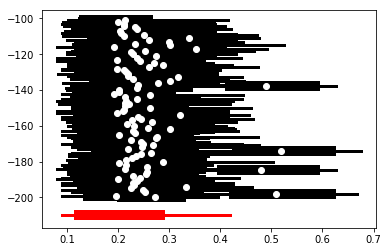

P-val: 0.565
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":1}, "d2":d2}


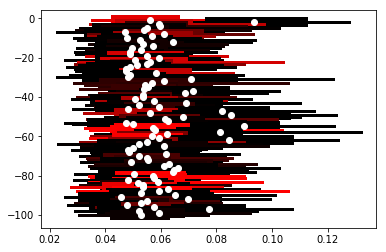

0.6839115486869537


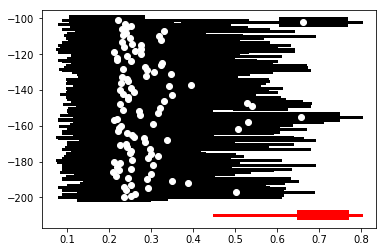

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":4}, "d2":d2}


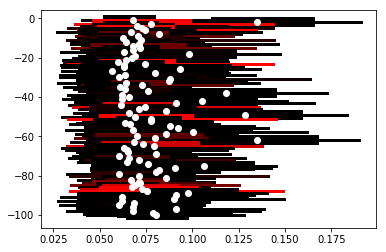

0.3535434769002883


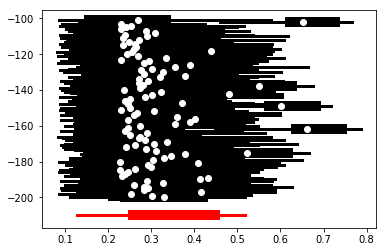

P-val: 0.605
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":4}, "d2":d2}


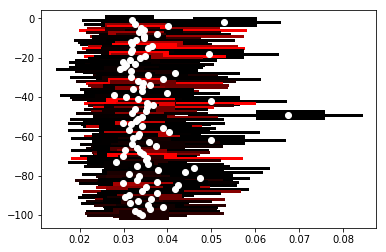

0.9997979797979798


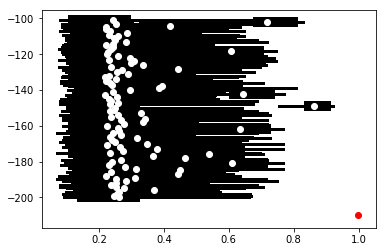

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":6}, "d2":d2}


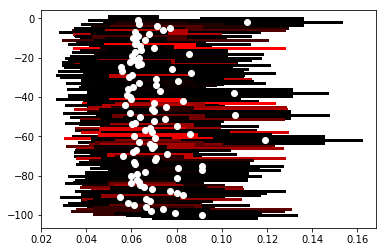

0.4521525364628826


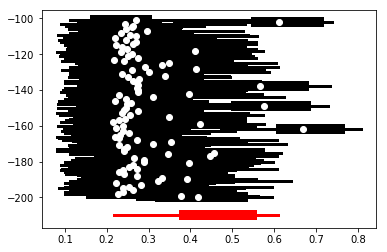

P-val: 0.063
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":1}, "d2":d2}


1.0


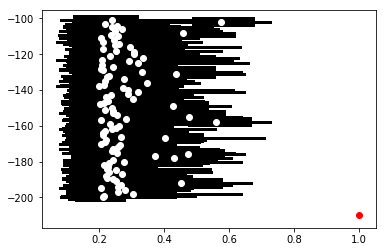

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":3}, "d2":d2}


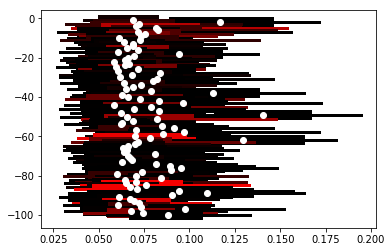

0.29733615345544656


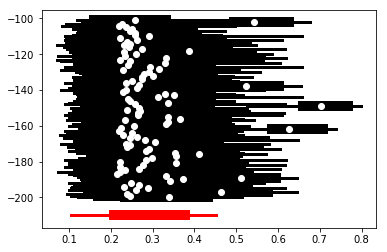

P-val: 0.931
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":5}, "d2":d2}


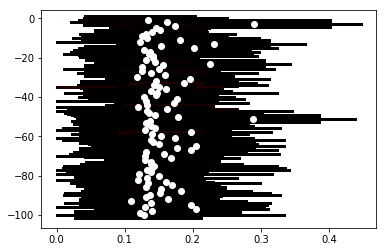

0.3378933241525289


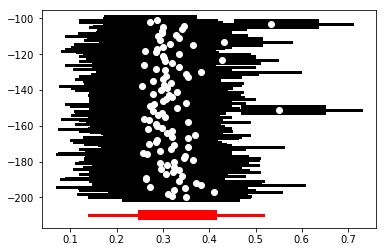

P-val: 0.679
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":5}, "d2":d2}


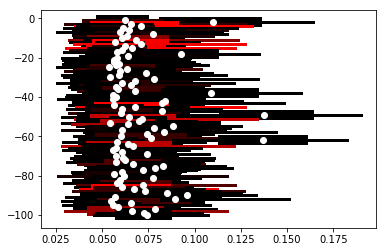

0.5096916964276627


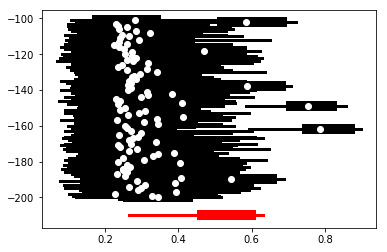

P-val: 0.037
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":5}, "d2":d2}


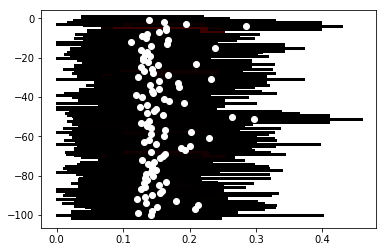

0.3448957464397818


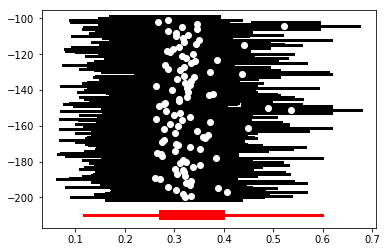

P-val: 0.725
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":5}, "d2":d2}


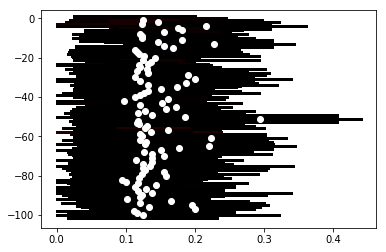

0.34124190059653975


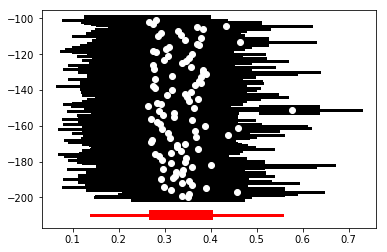

P-val: 0.913
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":2}, "d2":d2}


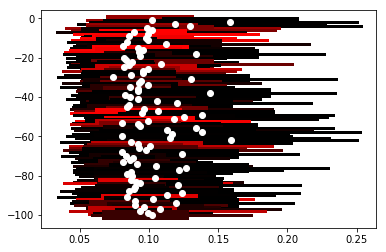

0.2072717996289425


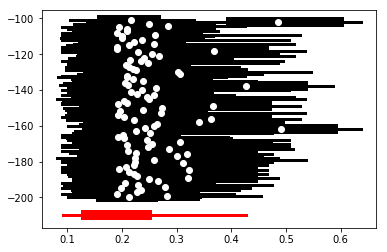

P-val: 0.49
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":4}, "d2":d2}


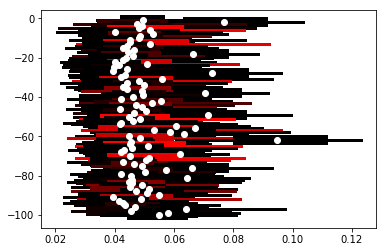

0.9100151676665668


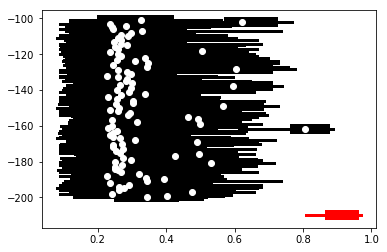

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.2040816326530612}, "d2":d2}


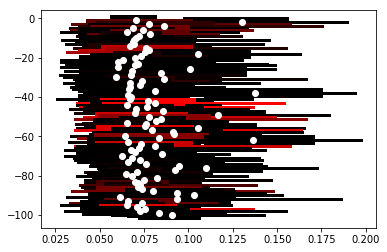

0.37325966308891556


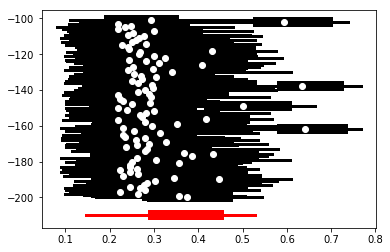

P-val: 0.321
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.0}, "d2":d2}


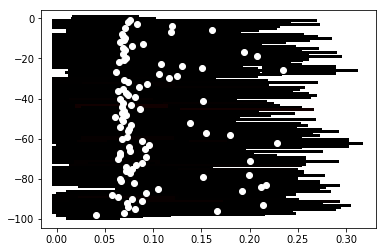

0.6059969624400636


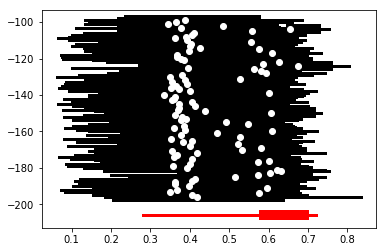

P-val: 0.099
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":5}, "d2":d2}


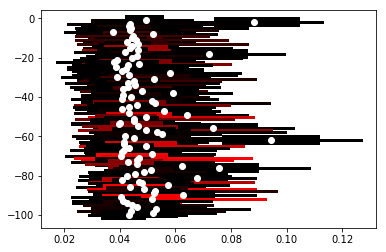

0.9152301491668209


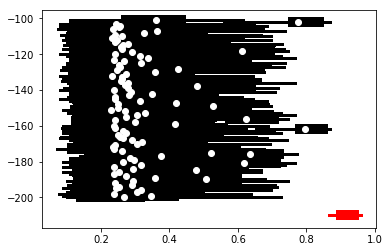

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":4}, "d2":d2}


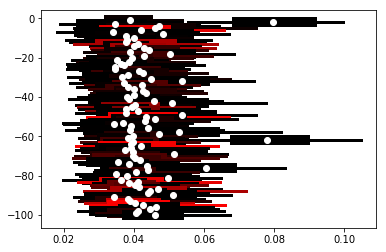

0.9805489944150105


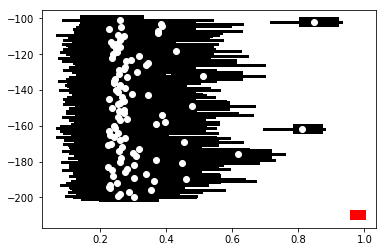

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":5}, "d2":d2}


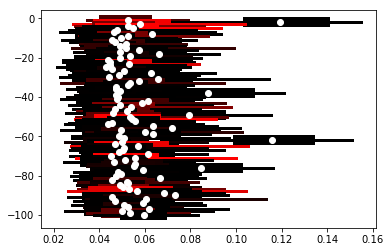

0.8067273200657956


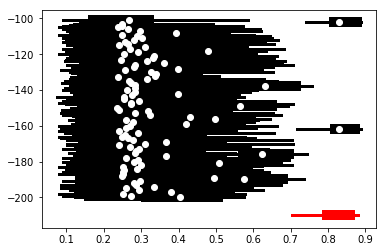

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.22058823529411764}, "d2":d2}


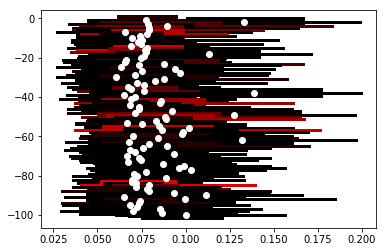

0.30123302985674116


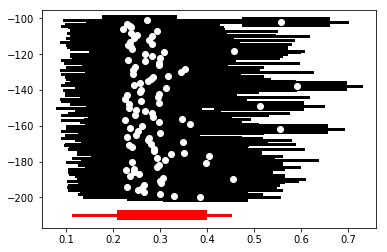

P-val: 0.875
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.609, "sigma":0.693}, "d2":d2}


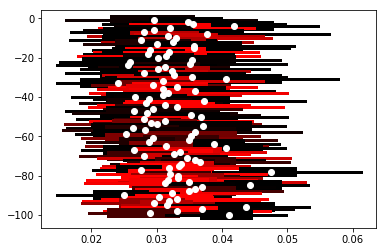

1.0


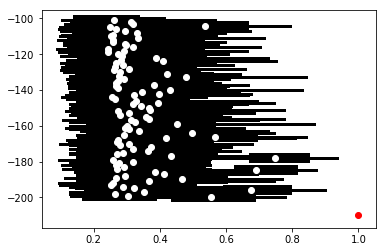

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":4}, "d2":d2}


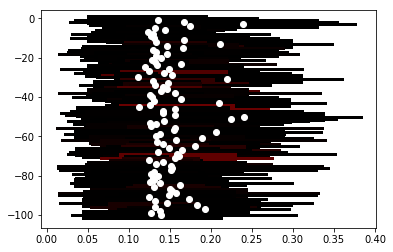

0.33192326428072005


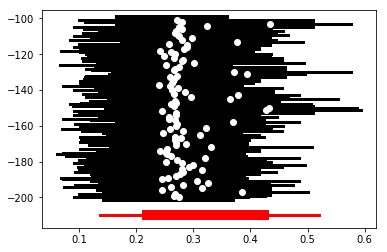

P-val: 0.27
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.405}, "d2":d2}


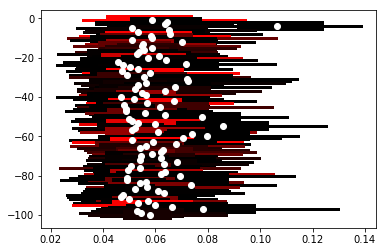

0.6574815387198304


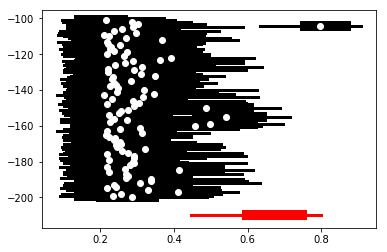

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":2}, "d2":d2}


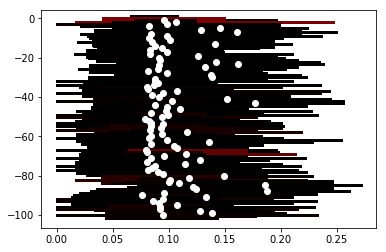

0.3492743511806473


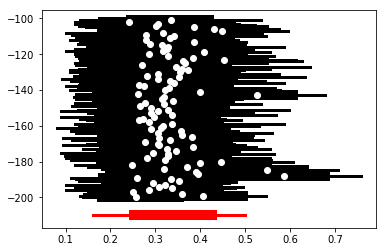

P-val: 0.788
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.0986122886681098, "sigma":3}, "d2":d2}


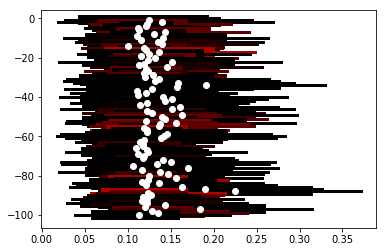

0.29970438935961763


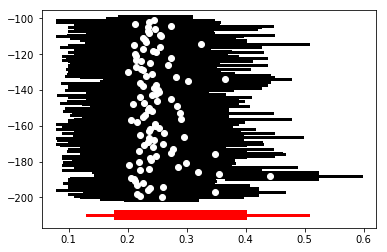

P-val: 0.192
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":4}, "d2":d2}


0.6899093282923916


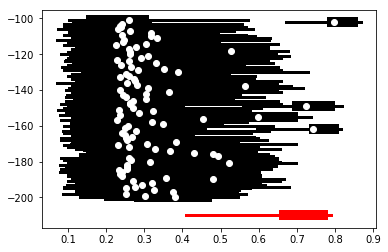

P-val: 0.001
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":1}, "d2":d2}


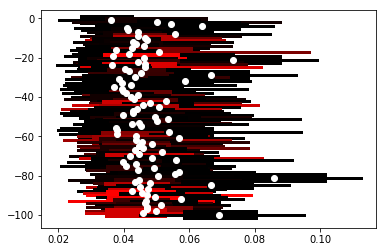

0.8771745130667074


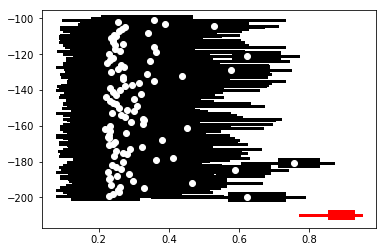

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.386, "sigma":0.916}, "d2":d2}


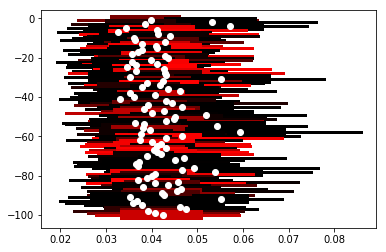

0.9987939187796332


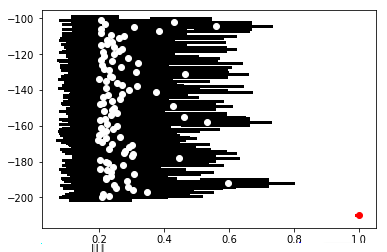

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.625}, "d2":d2}


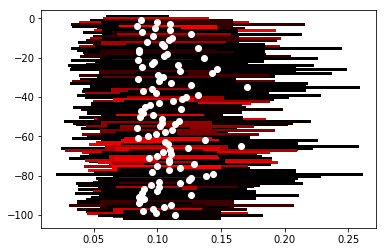

0.23643724771383096


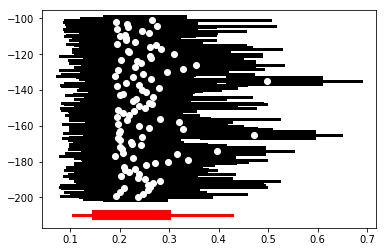

P-val: 0.866
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":2}, "d2":d2}


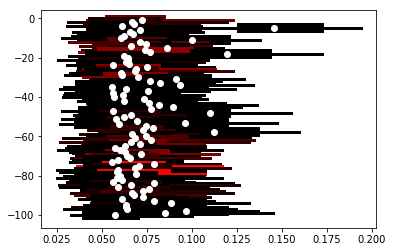

0.35479074417645856


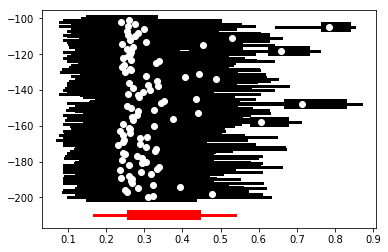

P-val: 0.668
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":3}, "d2":d2}


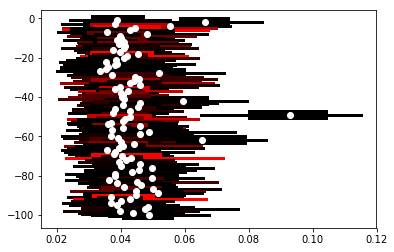

0.9743887645654952


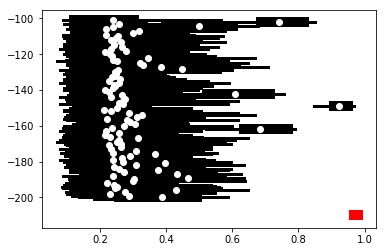

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.916}, "d2":d2}


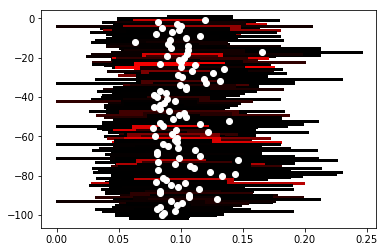

0.29457054236877506


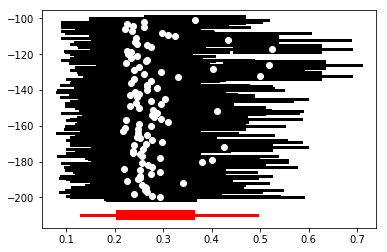

P-val: 0.786
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1, "sigma":2}, "d2":d2}


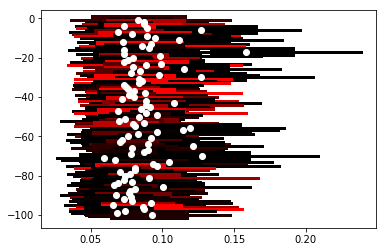

0.23541878685869846


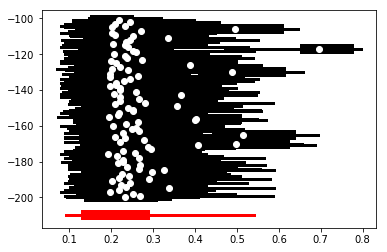

P-val: 0.744
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":3}, "d2":d2}


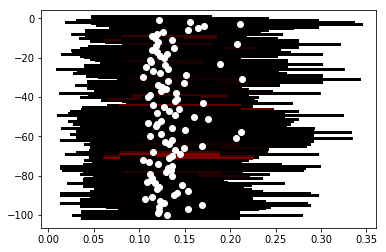

0.2975216728195016


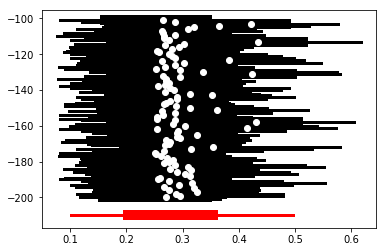

P-val: 0.912
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":3}, "d2":d2}


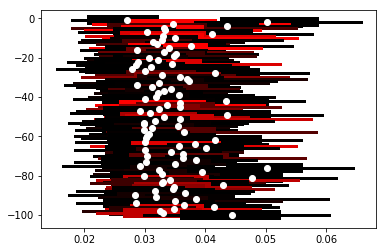

1.0


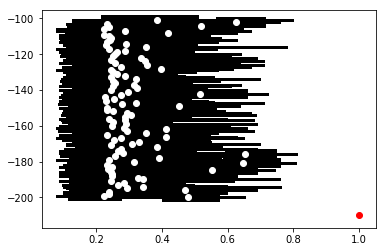

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.693, "sigma":0.693}, "d2":d2}


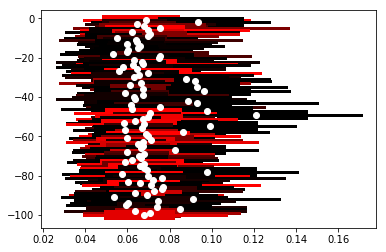

0.2333379813281139


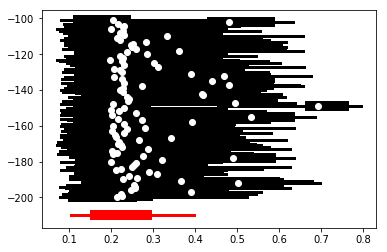

P-val: 0.66
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.693}, "d2":d2}


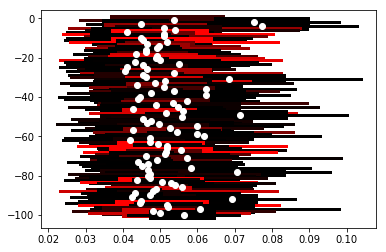

0.9054110641444957


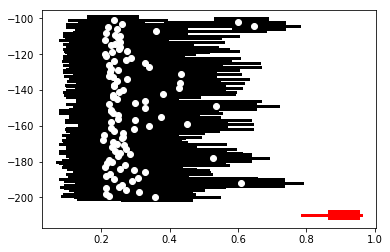

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":5}, "d2":d2}


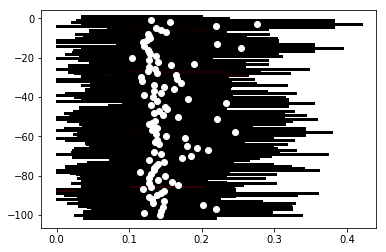

0.3421234677938654


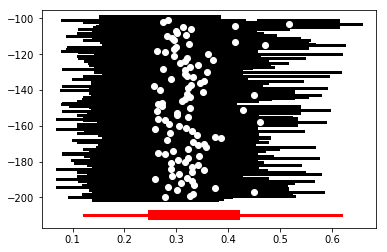

P-val: 0.691
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.25}, "d2":d2}


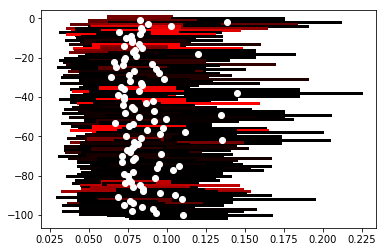

0.25821604388084507


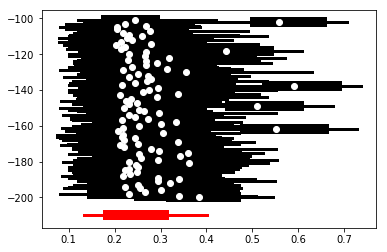

P-val: 0.831
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":4}, "d2":d2}


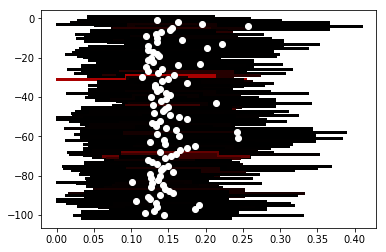

0.3164066690468752


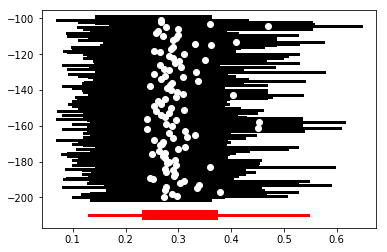

P-val: 0.629
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":3}, "d2":d2}


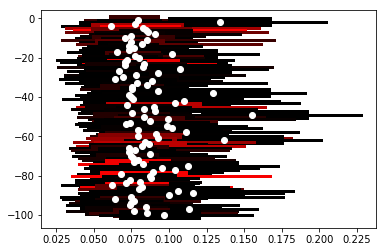

0.241249815852614


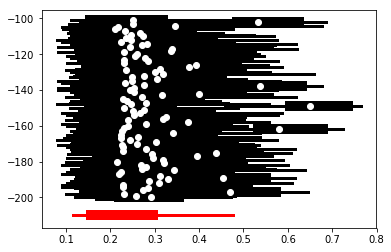

P-val: 0.547
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.405}, "d2":d2}


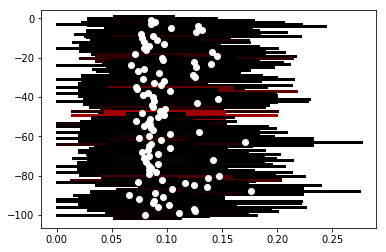

0.3626995960020997


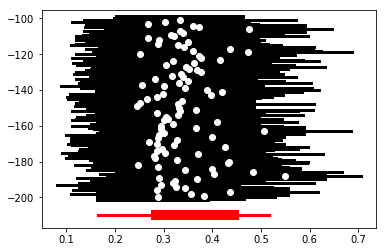

P-val: 0.694
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":1.0}, "d2":d2}


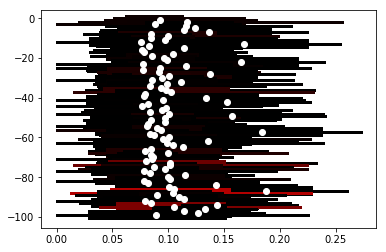

0.334339906185479


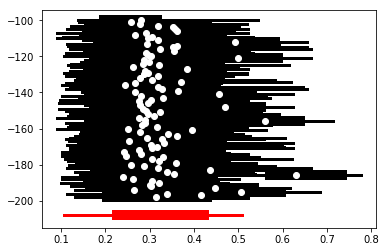

P-val: 0.87
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":2, "sigma":3}, "d2":d2}


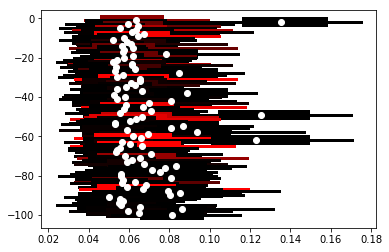

0.5448916879716585


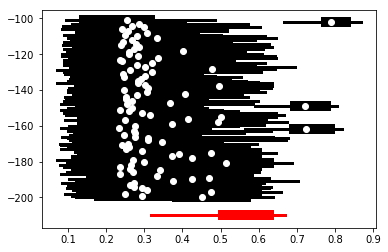

P-val: 0.034
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":0.693}, "d2":d2}


0.28654021681149816


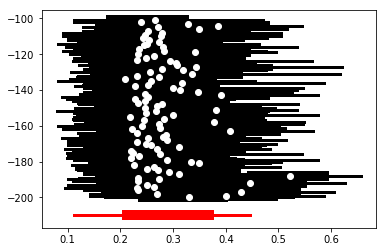

P-val: 0.924
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":0, "sigma":1}, "d2":d2}


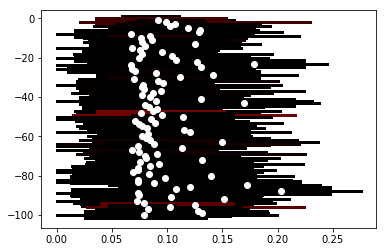

0.436030502133687


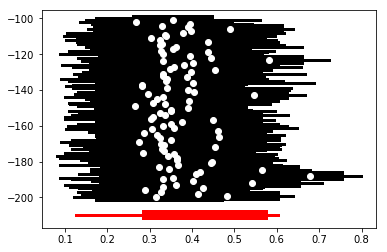

P-val: 0.357
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.3862943611198906, "sigma":3}, "d2":d2}


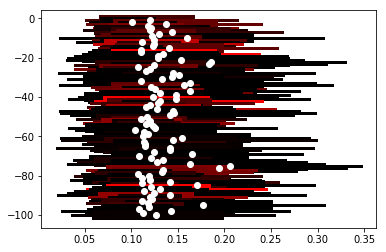

0.28705427369635766


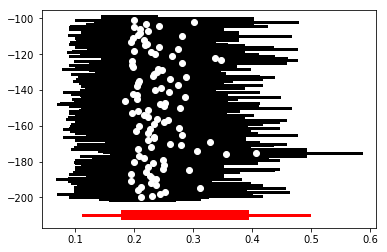

P-val: 0.23
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.609, "sigma":0.0}, "d2":d2}


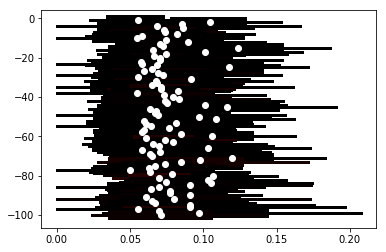

0.3611486675348051


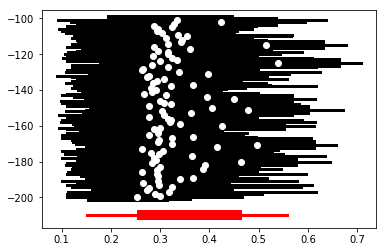

P-val: 0.519
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.189873417721519}, "d2":d2}


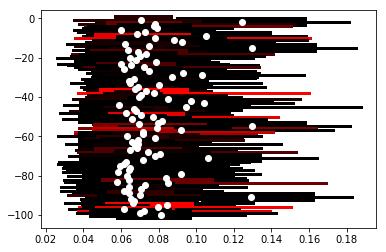

0.428450855281194


P-val: 0.129
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.6094379124341003, "sigma":3}, "d2":d2}


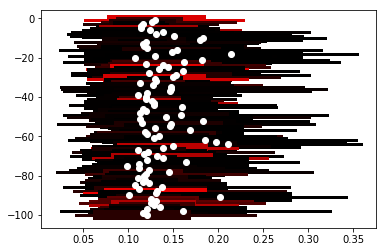

0.2655182079314075


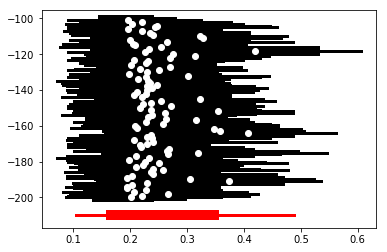

P-val: 0.656
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.2631578947368421}, "d2":d2}


0.2333310225917921


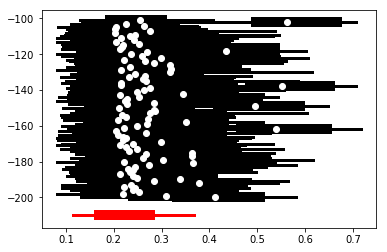

P-val: 0.632
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.8108108108108107}, "d2":d2}


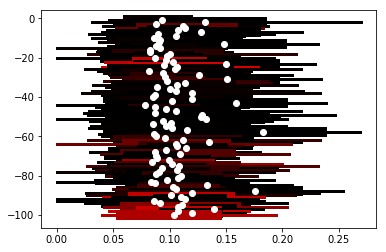

0.2480627303436213


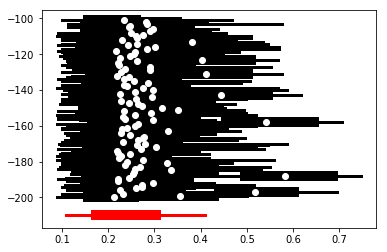

P-val: 0.688
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.37037037037037035}, "d2":d2}


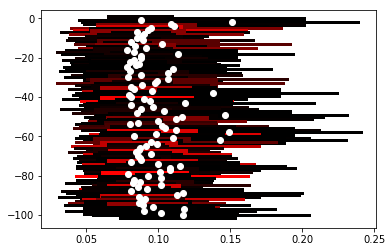

0.2364658355063363


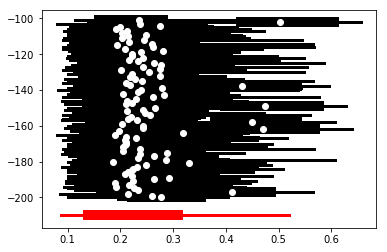

P-val: 0.866
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":3, "sigma":1}, "d2":d2}


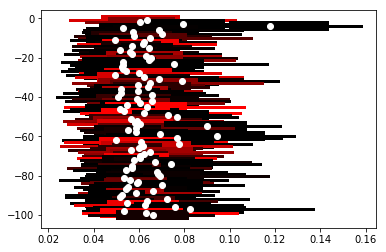

0.5657714595725825


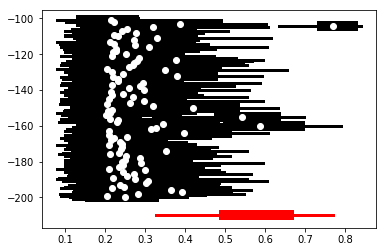

P-val: 0.001
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":8}, "d2":d2}


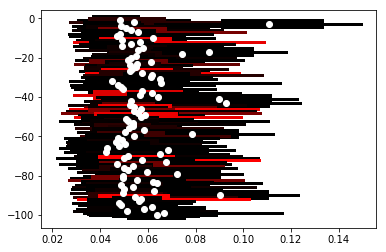

0.765290333377962


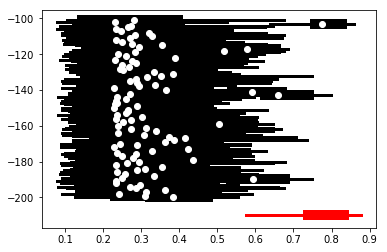

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":1.0, "sigma":1.0}, "d2":d2}


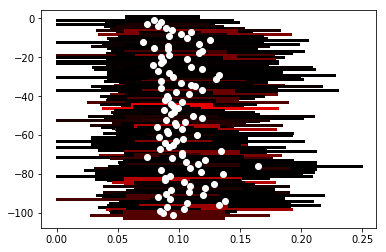

0.2483814184611025


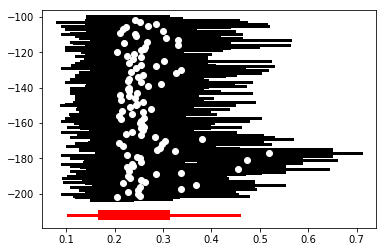

P-val: 0.795
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":4, "sigma":1}, "d2":d2}


0.7999298786306152


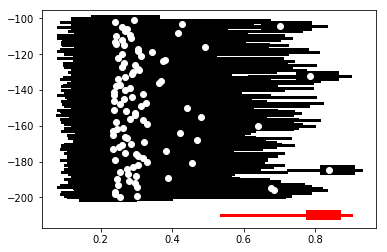

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.normalvariate, "params":{"mu":5, "sigma":5}, "d2":d2}


1.0


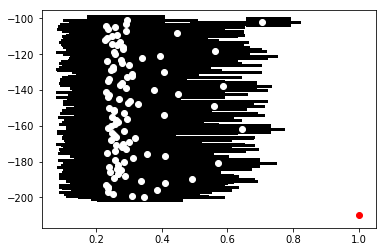

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":1}, "d2":d2}


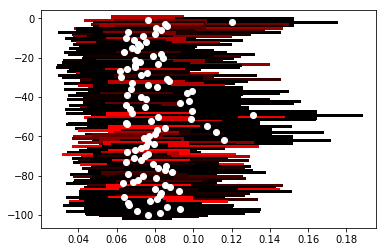

0.22187038701766248


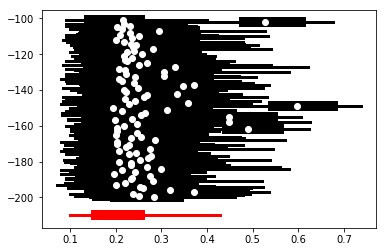

P-val: 0.599
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":1.099, "sigma":0.916}, "d2":d2}


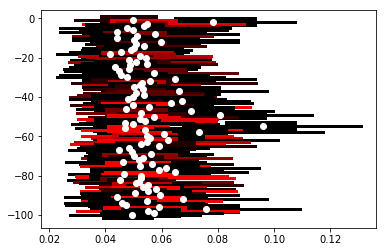

0.8220156541216924


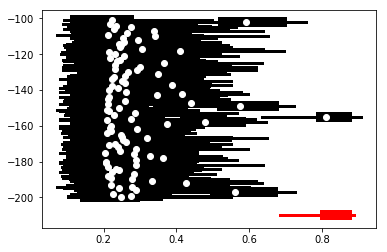

P-val: 0.0
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":4}, "d2":d2}


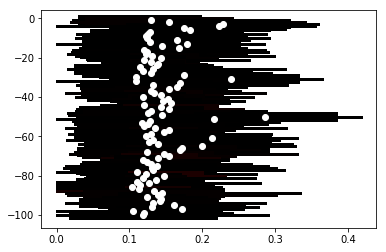

0.31556147944217944


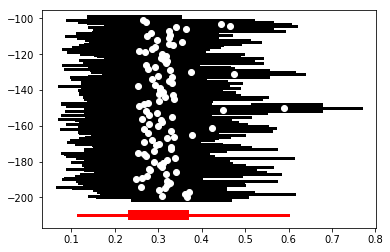

P-val: 0.982
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.0, "sigma":2}, "d2":d2}


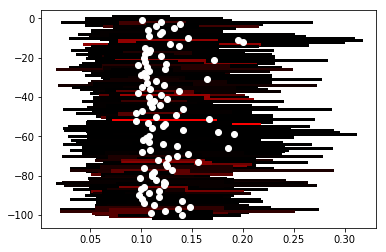

0.2530317976237668


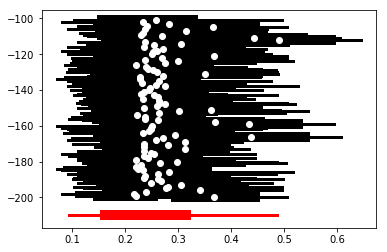

P-val: 0.754
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.expovariate, "params":{"lambd":0.32608695652173914}, "d2":d2}


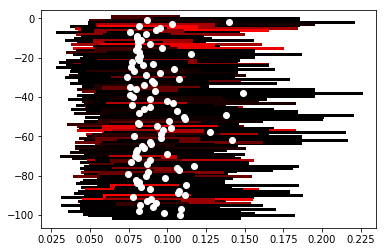

0.21692121743417764


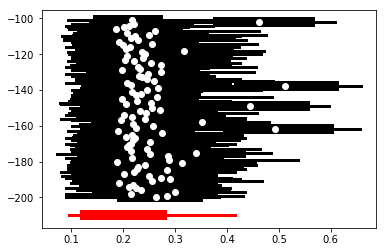

P-val: 0.615
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":3}, "d2":d2}


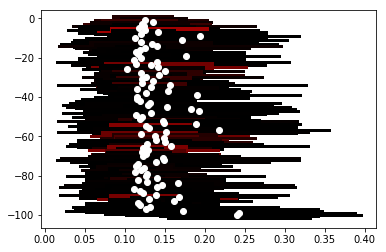

0.2734501548198161


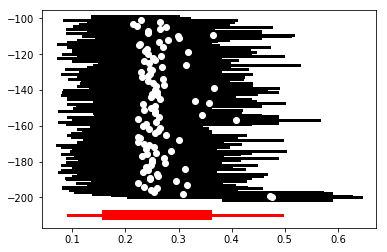

P-val: 0.859
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.lognormvariate, "params":{"mu":0.6931471805599453, "sigma":5}, "d2":d2}


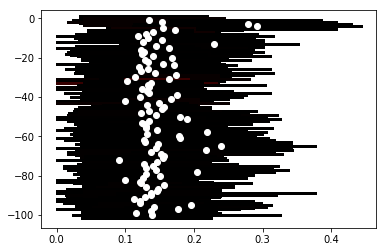

0.3495129181569534


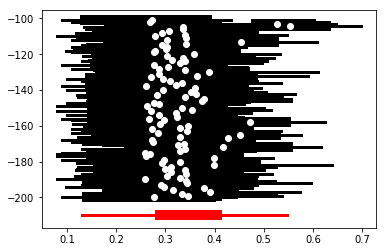

P-val: 0.669
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":4}, "d2":d2}


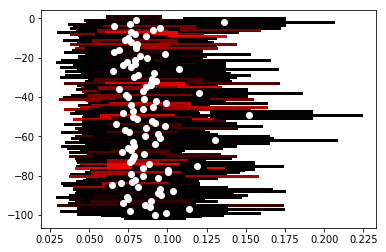

0.2556007219257587


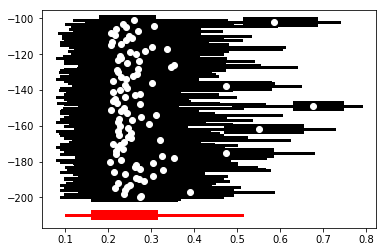

P-val: 0.867
{"num_familias":269, "num_abejas":3000, %, "randomfun":random.uniform, "params":{"a":0, "b":10}, "d2":d2}


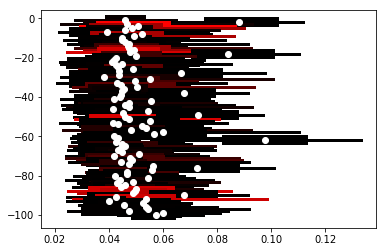

OperationalError: (2003, "Can't connect to MySQL server on 'ec2-18-221-141-77.us-east-2.compute.amazonaws.com' ([Errno 8] nodename nor servname provided, or not known)")

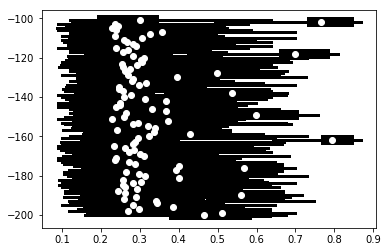

In [195]:
i=0
pvals_reg={}
for a in generic_task:
    means=[]
    print(a)
    print(str(i)+"/"+str(len(generic_task)), end="          \r")
    i+=1
    conn=get_connection()
    with conn.cursor() as cursor:
        sql="select * from tasks_abejas where task_params like \""+a.replace("\"", "\\\"")+"\""
        cursor.execute(sql)
        aa = cursor.fetchall()
    lista_difs=[str(aaa["task_id"]) for aaa in aa]
    condit="("+", ".join(lista_difs)+")"
    with conn.cursor() as cursor:
        sql="select * from distancias_geom where ca in "+condit+"  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
    conn.close()
    
    df=pd.DataFrame(aa)
    curvas=list(set(list(df["ca"])+list(df["cb"])))
    
    j=0
    for curva in curvas:
        j=j-1
        lista=list(df[(df.ca==curva) | (df.cb==curva)]["distancia"])
        listaor=list(df[(df.ca!=curva) & (df.cb!=curva)]["distancia"])
        kst=ks_2samp(lista, listaor)
        plt.scatter( np.mean(lista), j ,  color="white", zorder=10)
        plt.plot([np.percentile(lista, 5), np.percentile(lista, 95)], [j,j], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=3)
        plt.plot([np.percentile(lista, 25), np.percentile(lista, 75)], [j,j], '-', color=(rangesin(kst.pvalue), 0,0), linewidth=10)
    plt.show() 
    
    for curva in curvas:
        j=j-1
        lista=list(df[(df.ca==curva) | (df.cb==curva)]["distancia"])
        lista3=[]
        for curva2 in curvas:
            if curva2!=curva:
                lista2=list(df[(df.ca==curva2) | (df.cb==curva2)]["distancia"])
                kst=ks_2samp(lista, lista2)
                lista3.append(kst.statistic)
        means.append(np.mean(lista3))    
        
        
        plt.scatter( np.mean(lista3), j ,  color="white", zorder=10)
        plt.plot([np.percentile(lista3, 5), np.percentile(lista3, 95)], [j,j], '-', color=(0, 0,0), linewidth=3)
        plt.plot([np.percentile(lista3, 25), np.percentile(lista3, 75)], [j,j], '-', color=(0, 0,0), linewidth=10)
    
    conn=get_connection()
    with conn.cursor() as cursor:
        sql="select * from distancias_geom where ca=0  and cb in "+condit
        cursor.execute(sql)
        aa = cursor.fetchall()
    conn.close()
    
    df2=pd.DataFrame(aa)
    j=j-10
    lista=list(df2[df2.ca==0]["distancia"])
    lista3=[]
    for curva2 in curvas:
        lista2=list(df[(df.ca==curva2) | (df.cb==curva2)]["distancia"])
        kst=ks_2samp(lista, lista2)
        if kst.statistic<1000 and kst.statistic>-1000: lista3.append(kst.statistic)

    means.append(np.mean(lista3))
    #plt.scatter( 0.8, j,  color="red", zorder=10)
    plt.scatter( np.mean(lista3), j ,  color="red", zorder=10)
    plt.plot([np.percentile(lista3, 5), np.percentile(lista3, 95)], [j,j], '-', color="red", linewidth=3)
    plt.plot([np.percentile(lista3, 25), np.percentile(lista3, 75)], [j,j], '-', color="red", linewidth=10)

    print(np.mean(lista3))
    plt.show() 
    
    x1=[0 for k in range(len(means)-1)]+[1]
    y = means
    X2 = sm.add_constant(x1)
    # Note the difference in argument order

    model = sm.OLS(y, np.array(X2)).fit()

    
    print("P-val: "+str(round(model.pvalues[1], 3)))
    pvals_reg[a]=model.pvalues[1]
    



0.963506421737965

In [181]:
np.mean(lista3

[0.07070707070707072,
 0.5331439393939394,
 0.4545454545454546,
 0.49041434755720476,
 0.3434343434343434,
 0.1414141414141414,
 0.2761286332714905,
 0.2222222222222222,
 0.1717171717171717,
 0.1743970315398887,
 0.1541950113378685,
 0.1659451659451659,
 0.2727272727272727,
 0.12121212121212122,
 0.1919191919191919,
 0.2424242424242424,
 0.3232323232323233,
 0.1515151515151515,
 0.15316429602143886,
 0.2222222222222222,
 0.1649144506287363,
 0.23232323232323238,
 0.16615130900845188,
 0.2222222222222222,
 0.32725211296639867,
 0.263146933250026,
 0.1515151515151515,
 0.2222222222222222,
 0.23582766439909297,
 0.2777777777777778,
 0.2222222222222222,
 0.2456194599051742,
 0.2367553081838797,
 0.17171717171717174,
 0.13471449185734907,
 0.2568542568542569,
 0.4747474747474748,
 0.21212121212121215,
 0.18563182848897133,
 0.26262626262626265,
 0.31313131313131315,
 0.42424242424242425,
 0.17614924757781897,
 0.172979797979798,
 0.1717171717171717,
 0.33333333333333326,
 0.2020202020202020